### Import Major Libraries

In [1]:
import json
import requests
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 14, 6
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

## Define Gameweek and Periods for FDR calculation

In [206]:
gameweek = 15
next_n_games = 2

#define percentage of time player needs to have played to be counted as active
min_min = ((gameweek-1)*90)/3.33     #<---- Currently 30% of playtime
print(min_min)

378.3783783783784


## Define Budget, Team Formation, and Budget Allocation by Position

In [207]:
#Budget
budget = 100

#Team Formation
DF = 3
MD = 4
ST = 3

#Total players needed per position
DF_max = 5
MD_max = 5
ST_max = 3

#Budget Allocation
GK_coef = 0.095
DF_coef = 0.285
MD_coef = 0.36
ST_coef = 0.26

print(sum([GK_coef, DF_coef, MD_coef, ST_coef]))

1.0


## Scraped list of Schedules

In [208]:
schedules = ['Arsenal NEW (A) BUR (H) LIV (A) TOT (H) WAT (A) AVL (H) MUN (A) BOU (H) SHU (A) CRY (H) WOL (H) LEI (A) SOU (H) NOR (A) BHA (H) WHU (A) MCI (H) EVE (A) BOU (A) CHE (H) MUN (H) CRY (A) SHU (H) CHE (A) BUR (A) NEW (H) EVE (H) MCI (A) WHU (H) BHA (A) SOU (A) NOR (H) WOL (A) LEI (H) TOT (A) LIV (H) AVL (A) WAT (H)',
 'Aston Villa TOT (A) BOU (H) EVE (H) CRY (A) WHU (H) ARS (A) BUR (H) NOR (A) BHA (H) MCI (A) LIV (H) WOL (A) NEW (H) MUN (A) CHE (A) LEI (H) SHU (A) SOU (H) NOR (H) WAT (A) BUR (A) MCI (H) BHA (A) WAT (H) BOU (A) TOT (H) SOU (A) SHU (H) LEI (A) CHE (H) NEW (A) WOL (H) LIV (A) MUN (H) CRY (H) EVE (A) ARS (H) WHU (A)',
 'Bournemouth SHU (H) AVL (A) MCI (H) LEI (A) EVE (H) SOU (A) WHU (H) ARS (A) NOR (H) WAT (A) MUN (H) NEW (A) WOL (H) TOT (A) CRY (A) LIV (H) CHE (A) BUR (H) ARS (H) BHA (A) WHU (A) WAT (H) NOR (A) BHA (H) AVL (H) SHU (A) BUR (A) CHE (H) LIV (A) CRY (H) WOL (A) NEW (H) MUN (A) TOT (H) LEI (H) MCI (A) SOU (H) EVE (A)',
 'Brighton WAT (A) WHU (H) SOU (H) MCI (A) BUR (H) NEW (A) CHE (A) TOT (H) AVL (A) EVE (H) NOR (H) MUN (A) LEI (H) LIV (A) ARS (A) WOL (H) CRY (A) SHU (H) TOT (A) BOU (H) CHE (H) EVE (A) AVL (H) BOU (A) WHU (A) WAT (H) SHU (A) CRY (H) WOL (A) ARS (H) LEI (A) MUN (H) NOR (A) LIV (H) MCI (H) SOU (A) NEW (H) BUR (A)',
 'Burnley SOU (H) ARS (A) WOL (A) LIV (H) BHA (A) NOR (H) AVL (A) EVE (H) LEI (A) CHE (H) SHU (A) WHU (H) WAT (A) CRY (H) MCI (H) TOT (A) NEW (H) BOU (A) EVE (A) MUN (H) AVL (H) CHE (A) LEI (H) MUN (A) ARS (H) SOU (A) BOU (H) NEW (A) TOT (H) MCI (A) WAT (H) CRY (A) SHU (H) WHU (A) LIV (A) WOL (H) NOR (A) BHA (H)',
 'Chelsea MUN (A) LEI (H) NOR (A) SHU (H) WOL (A) LIV (H) BHA (H) SOU (A) NEW (H) BUR (A) WAT (A) CRY (H) MCI (A) WHU (H) AVL (H) EVE (A) BOU (H) TOT (A) SOU (H) ARS (A) BHA (A) BUR (H) NEW (A) ARS (H) LEI (A) MUN (H) TOT (H) BOU (A) EVE (H) AVL (A) MCI (H) WHU (A) WAT (H) CRY (A) SHU (A) NOR (H) LIV (A) WOL (H)',
 'Crystal Palace EVE (H) SHU (A) MUN (A) AVL (H) TOT (A) WOL (H) NOR (H) WHU (A) MCI (H) ARS (A) LEI (H) CHE (A) LIV (H) BUR (A) BOU (H) WAT (A) BHA (H) NEW (A) WHU (H) SOU (A) NOR (A) ARS (H) MCI (A) SOU (H) SHU (H) EVE (A) NEW (H) BHA (A) WAT (H) BOU (A) LIV (A) BUR (H) LEI (A) CHE (H) AVL (A) MUN (H) WOL (A) TOT (H)',
 'Everton CRY (A) WAT (H) AVL (A) WOL (H) BOU (A) SHU (H) MCI (H) BUR (A) WHU (H) BHA (A) TOT (H) SOU (A) NOR (H) LEI (A) LIV (A) CHE (H) MUN (A) ARS (H) BUR (H) NEW (A) MCI (A) BHA (H) WHU (A) NEW (H) WAT (A) CRY (H) ARS (A) MUN (H) CHE (A) LIV (H) NOR (A) LEI (H) TOT (A) SOU (H) WOL (A) AVL (H) SHU (A) BOU (H)',
 'Leicester WOL (H) CHE (A) SHU (A) BOU (H) MUN (A) TOT (H) NEW (H) LIV (A) BUR (H) SOU (A) CRY (A) ARS (H) BHA (A) EVE (H) WAT (H) AVL (A) NOR (H) MCI (A) LIV (H) WHU (A) NEW (A) SOU (H) BUR (A) WHU (H) CHE (H) WOL (A) MCI (H) NOR (A) AVL (H) WAT (A) BHA (H) EVE (A) CRY (H) ARS (A) BOU (A) SHU (H) TOT (A) MUN (H)',
 'Liverpool NOR (H) SOU (A) ARS (H) BUR (A) NEW (H) CHE (A) SHU (A) LEI (H) MUN (A) TOT (H) AVL (A) MCI (H) CRY (A) BHA (H) EVE (H) BOU (A) WAT (H) WHU (A) LEI (A) WOL (H) SHU (H) TOT (A) MUN (H) WOL (A) SOU (H) NOR (A) WHU (H) WAT (A) BOU (H) EVE (A) CRY (H) MCI (A) AVL (H) BHA (A) BUR (H) ARS (A) CHE (H) NEW (A)',
 'Man City WHU (A) TOT (H) BOU (A) BHA (H) NOR (A) WAT (H) EVE (A) WOL (H) CRY (A) AVL (H) SOU (H) LIV (A) CHE (H) NEW (A) BUR (A) MUN (H) ARS (A) LEI (H) WOL (A) SHU (H) EVE (H) AVL (A) CRY (H) SHU (A) TOT (A) WHU (H) LEI (A) ARS (H) MUN (A) BUR (H) CHE (A) LIV (H) SOU (A) NEW (H) BHA (A) BOU (H) WAT (A) NOR (H)',
 'Man Utd CHE (H) WOL (A) CRY (H) SOU (A) LEI (H) WHU (A) ARS (H) NEW (A) LIV (H) NOR (A) BOU (A) BHA (H) SHU (A) AVL (H) TOT (H) MCI (A) EVE (H) WAT (A) NEW (H) BUR (A) ARS (A) NOR (H) LIV (A) BUR (H) WOL (H) CHE (A) WAT (H) EVE (A) MCI (H) TOT (A) SHU (H) BHA (A) BOU (H) AVL (A) SOU (H) CRY (A) WHU (H) LEI (A)',
 'Newcastle ARS (H) NOR (A) TOT (A) WAT (H) LIV (A) BHA (H) LEI (A) MUN (H) CHE (A) WOL (H) WHU (A) BOU (H) AVL (A) MCI (H) SHU (A) SOU (H) BUR (A) CRY (H) MUN (A) EVE (H) LEI (H) WOL (A) CHE (H) EVE (A) NOR (H) ARS (A) CRY (A) BUR (H) SOU (A) SHU (H) AVL (H) BOU (A) WHU (H) MCI (A) WAT (A) TOT (H) BHA (A) LIV (H)',
 'Norwich LIV (A) NEW (H) CHE (H) WHU (A) MCI (H) BUR (A) CRY (A) AVL (H) BOU (A) MUN (H) BHA (A) WAT (H) EVE (A) ARS (H) SOU (A) SHU (H) LEI (A) WOL (H) AVL (A) TOT (H) CRY (H) MUN (A) BOU (H) TOT (A) NEW (A) LIV (H) WOL (A) LEI (H) SHU (A) SOU (H) EVE (H) ARS (A) BHA (H) WAT (A) WHU (H) CHE (A) BUR (H) MCI (A)',
 'Sheffield Utd BOU (A) CRY (H) LEI (H) CHE (A) SOU (H) EVE (A) LIV (H) WAT (A) ARS (H) WHU (A) BUR (H) TOT (A) MUN (H) WOL (A) NEW (H) NOR (A) AVL (H) BHA (A) WAT (H) MCI (A) LIV (A) WHU (H) ARS (A) MCI (H) CRY (A) BOU (H) BHA (H) AVL (A) NOR (H) NEW (A) MUN (A) TOT (H) BUR (A) WOL (H) CHE (H) LEI (A) EVE (H) SOU (A)',
 'Southampton BUR (A) LIV (H) BHA (A) MUN (H) SHU (A) BOU (H) TOT (A) CHE (H) WOL (A) LEI (H) MCI (A) EVE (H) ARS (A) WAT (H) NOR (H) NEW (A) WHU (H) AVL (A) CHE (A) CRY (H) TOT (H) LEI (A) WOL (H) CRY (A) LIV (A) BUR (H) AVL (H) WHU (A) NEW (H) NOR (A) ARS (H) WAT (A) MCI (H) EVE (A) MUN (A) BHA (H) BOU (A) SHU (H)',
 'Spurs AVL (H) MCI (A) NEW (H) ARS (A) CRY (H) LEI (A) SOU (H) BHA (A) WAT (H) LIV (A) EVE (A) SHU (H) WHU (A) BOU (H) MUN (A) BUR (H) WOL (A) CHE (H) BHA (H) NOR (A) SOU (A) LIV (H) WAT (A) NOR (H) MCI (H) AVL (A) CHE (A) WOL (H) BUR (A) MUN (H) WHU (H) SHU (A) EVE (H) BOU (A) ARS (H) NEW (A) LEI (H) CRY (A)',
 'Watford BHA (H) EVE (A) WHU (H) NEW (A) ARS (H) MCI (A) WOL (A) SHU (H) TOT (A) BOU (H) CHE (H) NOR (A) BUR (H) SOU (A) LEI (A) CRY (H) LIV (A) MUN (H) SHU (A) AVL (H) WOL (H) BOU (A) TOT (H) AVL (A) EVE (H) BHA (A) MUN (A) LIV (H) CRY (A) LEI (H) BUR (A) SOU (H) CHE (A) NOR (H) NEW (H) WHU (A) MCI (H) ARS (A)',
 'West Ham MCI (H) BHA (A) WAT (A) NOR (H) AVL (A) MUN (H) BOU (A) CRY (H) EVE (A) SHU (H) NEW (H) BUR (A) TOT (H) CHE (A) WOL (A) ARS (H) SOU (A) LIV (H) CRY (A) LEI (H) BOU (H) SHU (A) EVE (H) LEI (A) BHA (H) MCI (A) LIV (A) SOU (H) ARS (A) WOL (H) TOT (A) CHE (H) NEW (A) BUR (H) NOR (A) WAT (H) MUN (A) AVL (H)',
 'Wolves LEI (A) MUN (H) BUR (H) EVE (A) CHE (H) CRY (A) WAT (H) MCI (A) SOU (H) NEW (A) ARS (A) AVL (H) BOU (A) SHU (H) WHU (H) BHA (A) TOT (H) NOR (A) MCI (H) LIV (A) WAT (A) NEW (H) SOU (A) LIV (H) MUN (A) LEI (H) NOR (H) TOT (A) BHA (H) WHU (A) BOU (H) AVL (A) ARS (H) SHU (A) EVE (H) BUR (A) CRY (H) CHE (A)']

### Import Data

In [209]:


# url = "https://fantasy.premierleague.com/drf/bootstrap-static"
url = 'https://fantasy.premierleague.com/api/bootstrap-static/'

def get_json_data(url):
    response = requests.get(url)
    jobs = response.json()
    return jobs

#filter out players with less than 330
all_players = get_json_data(url)['elements']
all_teams = get_json_data(url)['teams']
positions = get_json_data(url)['element_types']

### Get Team Table

In [210]:
table_url = 'https://www.premierleague.com/tables'

def build_table(table_url):
    team_table = pd.read_html(table_url)
    team_df = pd.DataFrame(team_table[0])
    team_df = team_df[team_df['Unnamed: 12'].isna()]
    team_df = team_df.iloc[:,1:10]
    team_df.Club = team_df.Club.map(lambda x: x[-3:])
    team_df.reset_index()
    team_df.index = np.arange(1, len(team_df) + 1)
    team_df.columns = ['Team', 'Played', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts']
    team_df.index.name = 'Position'
    
    return team_df

In [211]:
table_url = 'https://www.premierleague.com/tables'
team_table = pd.read_html(table_url)
team_table[0]

,Position Pos,Club,Played Pl,Won W,Drawn D,Lost L,GF,GA,GD,Points Pts,Form,Next,Unnamed: 12
0,1 Previous Position 1,LiverpoolLIV,14,13,1,0,32,12,+20,40,W Sunday 27 October 2019 LIV 2 -1 TOT W ...,Everton Wednesday 04 December 2019 LIV 20:1...,NaN
1,Liverpool Recent Result - Saturday 30 Novembe...,Liverpool Recent Result - Saturday 30 Novembe...,Liverpool Recent Result - Saturday 30 Novembe...,Liverpool Recent Result - Saturday 30 Novembe...,Liverpool Recent Result - Saturday 30 Novembe...,Liverpool Recent Result - Saturday 30 Novembe...,Liverpool Recent Result - Saturday 30 Novembe...,Liverpool Recent Result - Saturday 30 Novembe...,Liverpool Recent Result - Saturday 30 Novembe...,Liverpool Recent Result - Saturday 30 Novembe...,Liverpool Recent Result - Saturday 30 Novembe...,Liverpool Recent Result - Saturday 30 Novembe...,Liverpool Recent Result - Saturday 30 Novembe...
2,2 Previous Position 2,Leicester CityLEI,14,10,2,2,33,9,+24,32,W Friday 25 October 2019 SOU 0 -9 LEI W ...,Watford Wednesday 04 December 2019 LEI 19:3...,NaN
3,Leicester City Recent Result - Sunday 1 Decem...,Leicester City Recent Result - Sunday 1 Decem...,Leicester City Recent Result - Sunday 1 Decem...,Leicester City Recent Result - Sunday 1 Decem...,Leicester City Recent Result - Sunday 1 Decem...,Leicester City Recent Result - Sunday 1 Decem...,Leicester City Recent Result - Sunday 1 Decem...,Leicester City Recent Result - Sunday 1 Decem...,Leicester City Recent Result - Sunday 1 Decem...,Leicester City Recent Result - Sunday 1 Decem...,Leicester City Recent Result - Sunday 1 Decem...,Leicester City Recent Result - Sunday 1 Decem...,Leicester City Recent Result - Sunday 1 Decem...
4,3 Previous Position 3,Manchester CityMCI,14,9,2,3,39,16,+23,29,W Saturday 26 October 2019 MCI 3 -0 AVL W...,Burnley Tuesday 03 December 2019 BUR 20:15 ...,NaN
5,Manchester City Recent Result - Saturday 30 N...,Manchester City Recent Result - Saturday 30 N...,Manchester City Recent Result - Saturday 30 N...,Manchester City Recent Result - Saturday 30 N...,Manchester City Recent Result - Saturday 30 N...,Manchester City Recent Result - Saturday 30 N...,Manchester City Recent Result - Saturday 30 N...,Manchester City Recent Result - Saturday 30 N...,Manchester City Recent Result - Saturday 30 N...,Manchester City Recent Result - Saturday 30 N...,Manchester City Recent Result - Saturday 30 N...,Manchester City Recent Result - Saturday 30 N...,Manchester City Recent Result - Saturday 30 N...
6,4 Previous Position 4,ChelseaCHE,14,8,2,4,28,20,+8,26,W Saturday 26 October 2019 BUR 2 -4 CHE W...,Aston Villa Wednesday 04 December 2019 CHE ...,NaN
7,Chelsea Recent Result - Saturday 30 November ...,Chelsea Recent Result - Saturday 30 November ...,Chelsea Recent Result - Saturday 30 November ...,Chelsea Recent Result - Saturday 30 November ...,Chelsea Recent Result - Saturday 30 November ...,Chelsea Recent Result - Saturday 30 November ...,Chelsea Recent Result - Saturday 30 November ...,Chelsea Recent Result - Saturday 30 November ...,Chelsea Recent Result - Saturday 30 November ...,Chelsea Recent Result - Saturday 30 November ...,Chelsea Recent Result - Saturday 30 November ...,Chelsea Recent Result - Saturday 30 November ...,Chelsea Recent Result - Saturday 30 November ...
8,5 Previous Position 10,Tottenham HotspurTOT,14,5,5,4,24,21,+3,20,L Sunday 27 October 2019 LIV 2 -1 TOT D ...,Manchester United Wednesday 04 December 2019 ...,NaN
9,Tottenham Hotspur Recent Result - Saturday 30...,Tottenham Hotspur Recent Result - Saturday 30...,Tottenham Hotspur Recent Result - Saturday 30...,Tottenham Hotspur Recent Result - Saturday 30...,Tottenham Hotspur Recent Result - Saturday 30...,Tottenham Hotspur Recent Result - Saturday 30...,Tottenham Hotspur Recent Result - Saturday 30...,Tottenham Hotspur Recent Result - Saturday 30...,Tottenham Hotspur Recent Result - Saturday 30...,Tottenham Hotspur Recent Result - Saturday 30...,Tottenham Hotspur Recent Result - Saturday 30...,Tottenham Hotspur Re

In [212]:
table_df = build_table(table_url)

In [213]:
table_df.head()

,Team,Played,W,D,L,GF,GA,GD,Pts
Position,,,,,,,,,
1,LIV,14,13,1,0,32,12,+20,40
2,LEI,14,10,2,2,33,9,+24,32
3,MCI,14,9,2,3,39,16,+23,29
4,CHE,14,8,2,4,28,20,+8,26
5,TOT,14,5,5,4,24,21,+3,20


### Try dynamic FDR Score

In [214]:
#List of teams
name_list = list(table_df.Team)

#list of points as integers
pts_list = [int(item) for item in table_df.Pts]
top_pts = max(pts_list)

#list of GF as integers
GF_list = [int(item) for item in table_df.GF]
top_GF = max(GF_list)

#list of GA as integers
GA_list = [int(item) for item in table_df.GA]
top_GA = max(GA_list)

In [215]:
top_pts, top_GF, top_GA

(40, 39, 32)

In [216]:
name_list[:5]

['LIV', 'LEI', 'MCI', 'CHE', 'TOT']

In [217]:
from scipy import stats
stats.percentileofscore(GF_list, 20)

62.5

In [218]:
scaled = [pts_list, GF_list, GA_list]

### Write Function to try scaled scores

In [219]:
def scaled_FDR(pts_list, GF_list, GA_list):
    #turn to array so you an use scaler
    arr_pts = np.array(pts_list).reshape(-1, 1)
    arr_GF = np.array(GF_list).reshape(-1, 1)
    arr_GA = np.array(GA_list).reshape(-1, 1)
    
    #instantiate scalers
    minmax = MinMaxScaler()
    robust = RobustScaler()
    
    #apply MinMax
    minmax_pts = minmax.fit_transform(arr_pts)
    minmax_GF = minmax.fit_transform(arr_GF)
    minmax_GA = minmax.fit_transform(arr_GA)
    
    #apply Robust
    robu_pts = robust.fit_transform(arr_pts)
    robu_GF = robust.fit_transform(arr_GF)
    robu_GA = robust.fit_transform(arr_GA)
    
    #add normalzied scores
    sum_minmax = (minmax_pts + minmax_GF + (1 - minmax_GA)).tolist()
    sum_robu = (robu_pts + robu_GF + minmax_GA*(-1)).tolist()
    
    minmax_fin = [item[0] for item in sum_minmax]
    robu_fin = [item[0] for item in sum_robu]
    
    return (minmax_fin, robu_fin)
    

In [220]:
scaled_scores = scaled_FDR(pts_list, GF_list, GA_list)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [221]:
scaled_scores[1]

[6.269565217391305,
 4.948148148148148,
 4.93268921095008,
 2.5291465378421902,
 0.6930756843800322,
 0.12624798711755236,
 -0.19613526570048306,
 -0.09951690821256037,
 0.02254428341384862,
 -0.2560386473429952,
 -1.2061191626409018,
 -0.9523349436392915,
 -1.2309178743961353,
 -1.7800322061191627,
 -0.7948470209339775,
 -1.492109500805153,
 -2.0318840579710145,
 -2.7185185185185183,
 -2.831561996779388,
 -4.233494363929147]

In [222]:
maybs = [item*2 for item in scaled_scores[0]]

In [223]:
maybs

[5.272463768115942,
 5.1,
 4.703804347826087,
 3.435144927536232,
 2.7065217391304346,
 2.721014492753623,
 2.8730072463768117,
 2.377355072463768,
 2.7293478260869564,
 2.401811594202899,
 2.1090579710144928,
 2.143478260869565,
 1.815942028985507,
 1.6362318840579708,
 2.107065217391304,
 1.8606884057971014,
 1.5778985507246377,
 0.65,
 0.7614130434782608,
 0.3478260869565215]

<function matplotlib.pyplot.show(*args, **kw)>

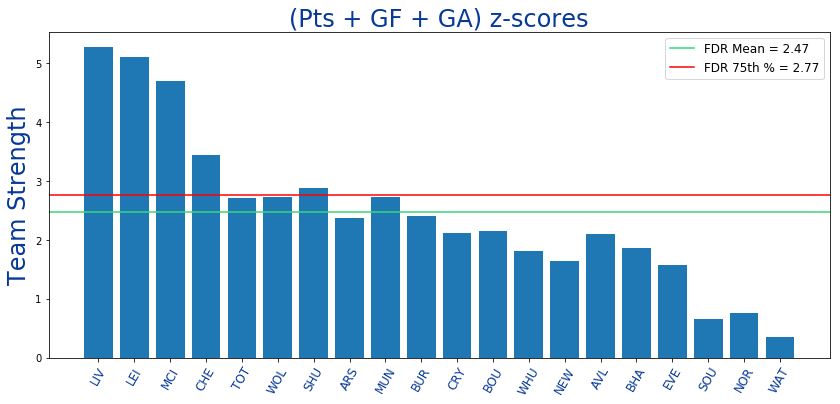

In [224]:
Team = name_list
strength = maybs

mean_FDR = round(np.mean([item for item in maybs]), 2)
FDR_75 = round(np.percentile([item for item in maybs], 75), 2)

plt.bar(Team, strength)
plt.axhline(y=mean_FDR, linestyle='-', color='#33D977', label='FDR Mean = ' + str(mean_FDR))
plt.axhline(y=FDR_75, linestyle='-', color='red', label='FDR 75th % = ' + str(FDR_75))
plt.ylabel('Team Strength', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('(Pts + GF + GA) z-scores', fontsize = 24, color = '#073997')
plt.legend(fontsize = '12')
plt.show

In [225]:
# import plotly.graph_objs as go


# fig = go.Figure([go.Bar(x=Team, y=strength, marker = {'color': '#82DFF1'})])
# fig.add_trace(go.Scatter(
#     x=['LIV', 'WAT'],
#     y=[mean_FDR, mean_FDR],
#     mode="lines",
# ))

# fig.layout.plot_bgcolor = '#082391'                
# fig.update_layout(
#     title='US Export of Plastic Scrap',
#     xaxis_tickfont_size=14,
#     yaxis=dict(
#         title='USD (millions)',
#         showgrid=False,
#         titlefont_size=16,
#         tickfont_size=14,
#     ))

# fig.write_image('figure.png')
# fig.show()

In [226]:
zipped_list = list(zip(name_list, pts_list, GF_list, GA_list))

In [227]:
zipped_list[:3]

[('LIV', 40, 32, 12), ('LEI', 32, 33, 9), ('MCI', 29, 39, 16)]

In [228]:
def get_percentiles(zipped_list):
    listy = []
    for item in zipped_list:
        team = item[0]
        pts_perc = stats.percentileofscore(pts_list, item[1])
        GF_perc = stats.percentileofscore(GF_list, item[2])
        GA_perc = stats.percentileofscore(GA_list, item[3])
        FDR = pts_perc + GF_perc + (100-GA_perc)
        tup = (team, FDR)
        listy.append(tup)
    return listy
    

In [229]:
FDR_new = get_percentiles(zipped_list)

In [230]:
FDR_new

[('LIV', 280.0),
 ('LEI', 285.0),
 ('MCI', 270.0),
 ('CHE', 225.0),
 ('TOT', 197.5),
 ('WOL', 205.0),
 ('SHU', 195.0),
 ('ARS', 170.0),
 ('MUN', 200.0),
 ('BUR', 172.5),
 ('CRY', 132.5),
 ('BOU', 145.0),
 ('WHU', 97.5),
 ('NEW', 77.5),
 ('AVL', 125.0),
 ('BHA', 102.5),
 ('EVE', 65.0),
 ('SOU', 42.5),
 ('NOR', 42.5),
 ('WAT', 20.0)]

In [231]:
mean_FDR = np.mean([item[1] for item in FDR_new])

In [232]:
mean_FDR

152.5

<function matplotlib.pyplot.show(*args, **kw)>

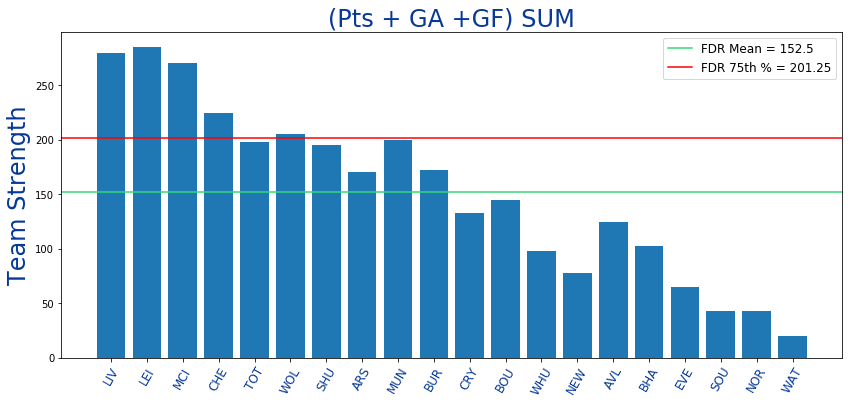

In [233]:
Team = [item[0] for item in FDR_new]
strength = [item[1] for item in FDR_new]

mean_FDR = np.mean([item[1] for item in FDR_new])
FDR_75 = np.percentile([item[1] for item in FDR_new], 75)

plt.bar(Team, strength)
plt.axhline(y=mean_FDR, linestyle='-', color='#33D977', label='FDR Mean = ' + str(mean_FDR))
plt.axhline(y=FDR_75, linestyle='-', color='red', label='FDR 75th % = ' + str(FDR_75))
plt.ylabel('Team Strength', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('(Pts + GA +GF) SUM', fontsize = 24, color = '#073997')
plt.legend(fontsize = '12')
plt.show

### Function to return percentile for each team

## Add player status and ROI, pts-per-90min metrics to final player_df

In [234]:
def attach_team_and_position(main_players, all_teams, positons):
    players = main_players.copy()
    for team in all_teams:
        for player in players:
            if team['code'] == player['team_code']:
                player['team_name'] = team['name']
    for position in positions:
        for player in players:
            if position['id'] == player['element_type']:
                player['position'] = position['singular_name']
    for player in players:
        if player['status'] == "a":
            player['status'] = "available"
        elif player['status'] == "d":
            player['status'] = "doubtful"
        elif player['status'] == "i":
            player['status'] = "injured"
        elif player['status'] == "s":
            player['status'] = "suspended"
    return players


#### Temporarily took out the "main_players" filter because no players have played 330 minutes ####

# player_positions_teams = attach_team_and_position(main_players, all_teams_new, positions)
player_positions_teams = attach_team_and_position(all_players, all_teams, positions)


def final_players_list(player_positions_teams):
    players = player_positions_teams.copy()
    empty = []
    for player in players:
        stats = dict(team_code = player['team_code'],
        team_name = player['team_name'],
        name = player['first_name'] + " " + player['second_name'],
        status = player['status'],
        position = player['position'],
        cost = (player['now_cost'])/10,
        total_points = player['total_points'],
        roi = round((player['total_points'] / player['now_cost'])*10, 2),
        pts_per_90min = round((player['total_points'] / (player['minutes'] + 1))*90, 2),
        bonus = player['bonus'],
        red_cards = player['red_cards'],
        minutes = player['minutes'],
        transfers_out = player['transfers_out'],
        transfers_in = player['transfers_in'])
        empty.append(stats)
    return empty

In [235]:
final = final_players_list(player_positions_teams)

In [236]:
final[0]

{'team_code': 3,
 'team_name': 'Arsenal',
 'name': 'Shkodran Mustafi',
 'status': 'available',
 'position': 'Defender',
 'cost': 5.2,
 'total_points': 4,
 'roi': 0.77,
 'pts_per_90min': 3.96,
 'bonus': 0,
 'red_cards': 0,
 'minutes': 90,
 'transfers_out': 30898,
 'transfers_in': 7220}

In [237]:
all_teams[0]

{'code': 3,
 'draw': 0,
 'form': None,
 'id': 1,
 'loss': 0,
 'name': 'Arsenal',
 'played': 0,
 'points': 0,
 'position': 0,
 'short_name': 'ARS',
 'strength': 4,
 'team_division': None,
 'unavailable': False,
 'win': 0,
 'strength_overall_home': 1230,
 'strength_overall_away': 1270,
 'strength_attack_home': 1150,
 'strength_attack_away': 1190,
 'strength_defence_home': 1280,
 'strength_defence_away': 1330}

### Get Total ROI, Points and 90min before filtering injured and FDR

In [238]:
total_roi = sorted(final, key = lambda x: x['roi'], reverse = True)

In [239]:
total_roi[:2]

[{'team_code': 49,
  'team_name': 'Sheffield Utd',
  'name': 'John Lundstram',
  'status': 'available',
  'position': 'Defender',
  'cost': 5.0,
  'total_points': 75,
  'roi': 15.0,
  'pts_per_90min': 5.49,
  'bonus': 10,
  'red_cards': 0,
  'minutes': 1228,
  'transfers_out': 294366,
  'transfers_in': 2807033},
 {'team_code': 36,
  'team_name': 'Brighton',
  'name': 'Mathew Ryan',
  'status': 'available',
  'position': 'Goalkeeper',
  'cost': 4.7,
  'total_points': 60,
  'roi': 12.77,
  'pts_per_90min': 4.28,
  'bonus': 11,
  'red_cards': 0,
  'minutes': 1260,
  'transfers_out': 450883,
  'transfers_in': 751333}]

### Total_Points

In [240]:
total_max_pts = sorted(total_roi, key = lambda x: x['total_points'], reverse = True)

In [241]:
total_max_pts[:2]

[{'team_code': 13,
  'team_name': 'Leicester',
  'name': 'Jamie Vardy',
  'status': 'available',
  'position': 'Forward',
  'cost': 9.8,
  'total_points': 110,
  'roi': 11.22,
  'pts_per_90min': 7.85,
  'bonus': 19,
  'red_cards': 0,
  'minutes': 1260,
  'transfers_out': 580867,
  'transfers_in': 2994197},
 {'team_code': 14,
  'team_name': 'Liverpool',
  'name': 'Sadio Mané',
  'status': 'available',
  'position': 'Midfielder',
  'cost': 12.2,
  'total_points': 94,
  'roi': 7.7,
  'pts_per_90min': 7.38,
  'bonus': 13,
  'red_cards': 0,
  'minutes': 1146,
  'transfers_out': 811418,
  'transfers_in': 2535594}]

### 90 min

In [242]:
total_90min = sorted(total_roi, key = lambda x: x['pts_per_90min'], reverse = True)

#define filter of minimum time played
min_min = min_min
total_90min = [player for player in total_90min if player['minutes'] >= min_min]

In [243]:
total_90min[:2]

[{'team_code': 49,
  'team_name': 'Sheffield Utd',
  'name': 'Lys Mousset',
  'status': 'available',
  'position': 'Forward',
  'cost': 5.1,
  'total_points': 53,
  'roi': 10.39,
  'pts_per_90min': 9.52,
  'bonus': 9,
  'red_cards': 0,
  'minutes': 500,
  'transfers_out': 77083,
  'transfers_in': 364644},
 {'team_code': 43,
  'team_name': 'Man City',
  'name': 'Riyad Mahrez',
  'status': 'available',
  'position': 'Midfielder',
  'cost': 8.3,
  'total_points': 58,
  'roi': 6.99,
  'pts_per_90min': 8.47,
  'bonus': 9,
  'red_cards': 0,
  'minutes': 615,
  'transfers_out': 785882,
  'transfers_in': 805721}]

### Create Players DataFrame

In [244]:
player_df = pd.DataFrame(final)

In [245]:
player_df.sort_values(by = ['roi'], ascending = False, inplace = True)

In [246]:
player_df.head(10)

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
396,10,5.0,1228,John Lundstram,Defender,5.49,0,15.00,available,49,Sheffield Utd,75,2807033,294366
98,11,4.7,1260,Mathew Ryan,Goalkeeper,4.28,0,12.77,available,36,Brighton,60,751333,450883
226,5,5.0,1260,Çaglar Söyüncü,Defender,4.50,0,12.60,available,13,Leicester,63,1391481,213154
376,5,4.6,1005,Todd Cantwell,Midfielder,5.10,0,12.39,available,45,Norwich,57,2293397,1271255
393,3,4.6,1260,George Baldock,Defender,4.00,0,12.17,available,49,Sheffield Utd,56,242623,48061
93,9,4.6,1170,Lewis Dunk,Defender,4.30,0,12.17,available,36,Brighton,56,724812,530633
222,9,6.4,1260,Ricardo Domingos Barbosa Pereira,Defender,5.35,0,11.72,available,13,Leicester,75,997439,346433
84,7,4.7,1260,Aaron Ramsdale,Goalkeeper,3.93,0,11.70,available,91,Bournemouth,55,359819,85923
128,6,4.7,1260,Nick Pope,Goalkeeper,3.93,0,11.70,available,90,Burnley,55,948663,338497
409,2,4.7,1170,Dean Henderson,Goalkeeper,4.15,0,11.49,available,49,Sheffield Utd,54,466374,170956


### Merge two team tables s owe have all data

In [247]:
def merged_teams(table_df, all_teams):
    table_dic = table_df.to_dict('records')
    
    for team in table_dic:
        for item in all_teams:
            if team['Team'] == item['short_name']:
                team['code'] = item['code']
                team['name'] = item['name']
                team['strength'] = item['strength']
            
    new_df = pd.DataFrame(table_dic)
    
    new_order = ['code', 'strength', 'Team','name', 'Played', 'W', 'L', 'D', 'GF', 'GA', 'GD', 'Pts']
    
    table_df = new_df[new_order]
    
    table_df.index = np.arange(1, len(table_df) + 1)
    table_df.index.name = 'Position'
    
    return table_df
    

In [248]:
team_df = merged_teams(table_df, all_teams)

In [249]:
team_df.head()

,code,strength,Team,name,Played,W,L,D,GF,GA,GD,Pts
Position,,,,,,,,,,,,
1,14,5,LIV,Liverpool,14,13,0,1,32,12,+20,40
2,13,4,LEI,Leicester,14,10,2,2,33,9,+24,32
3,43,5,MCI,Man City,14,9,3,2,39,16,+23,29
4,8,4,CHE,Chelsea,14,8,4,2,28,20,+8,26
5,6,4,TOT,Spurs,14,5,4,5,24,21,+3,20


In [250]:
team_names = list(team_df.name)

In [251]:
team_names.sort()

In [252]:
team_names

['Arsenal',
 'Aston Villa',
 'Bournemouth',
 'Brighton',
 'Burnley',
 'Chelsea',
 'Crystal Palace',
 'Everton',
 'Leicester',
 'Liverpool',
 'Man City',
 'Man Utd',
 'Newcastle',
 'Norwich',
 'Sheffield Utd',
 'Southampton',
 'Spurs',
 'Watford',
 'West Ham',
 'Wolves']

## Create Schedule DF

In [253]:
def extract_sched(schedules):
    dic = {}
    for i, item in enumerate(schedules):
        name = item.partition(team_names[i])[1]
        sche = item.partition(team_names[i])[2]
        sche = sche.split()
        clean = [item for item in sche if item != "(A)"]
        clean2 = [item for item in clean if item != "(H)"]
        dic[name] = clean2
    return dic

In [254]:
wonders = extract_sched(schedules)

In [255]:
schedule_df = pd.DataFrame(wonders)

In [256]:
schedule_df.index.name = 'Gameweek'

In [257]:
schedule_df.head()

,Arsenal,Aston Villa,Bournemouth,Brighton,Burnley,Chelsea,Crystal Palace,Everton,Leicester,Liverpool,Man City,Man Utd,Newcastle,Norwich,Sheffield Utd,Southampton,Spurs,Watford,West Ham,Wolves
Gameweek,,,,,,,,,,,,,,,,,,,,
0,NEW,TOT,SHU,WAT,SOU,MUN,EVE,CRY,WOL,NOR,WHU,CHE,ARS,LIV,BOU,BUR,AVL,BHA,MCI,LEI
1,BUR,BOU,AVL,WHU,ARS,LEI,SHU,WAT,CHE,SOU,TOT,WOL,NOR,NEW,CRY,LIV,MCI,EVE,BHA,MUN
2,LIV,EVE,MCI,SOU,WOL,NOR,MUN,AVL,SHU,ARS,BOU,CRY,TOT,CHE,LEI,BHA,NEW,WHU,WAT,BUR
3,TOT,CRY,LEI,MCI,LIV,SHU,AVL,WOL,BOU,BUR,BHA,SOU,WAT,WHU,CHE,MUN,ARS,NEW,NOR,EVE
4,WAT,WHU,EVE,BUR,BHA,WOL,TOT,BOU,MUN,NEW,NOR,LEI,LIV,MCI,SOU,SHU,CRY,ARS,AVL,CHE


In [258]:
schedule_df.Arsenal[0:3]

Gameweek
0    NEW
1    BUR
2    LIV
Name: Arsenal, dtype: object

## Create FDR scores for calculating next-n opponents AVG strength

In [259]:
scores = list(zip(team_df.Team, team_df.strength))

In [260]:
scores = dict(scores)

In [261]:
sorted(scores.items(), key = lambda x: x[1], reverse = True)

[('LIV', 5),
 ('MCI', 5),
 ('LEI', 4),
 ('CHE', 4),
 ('TOT', 4),
 ('ARS', 4),
 ('MUN', 4),
 ('WOL', 3),
 ('SHU', 3),
 ('BUR', 3),
 ('CRY', 3),
 ('BOU', 3),
 ('WHU', 3),
 ('NEW', 3),
 ('BHA', 3),
 ('EVE', 3),
 ('WAT', 3),
 ('AVL', 2),
 ('SOU', 2),
 ('NOR', 2)]

No handles with labels found to put in legend.


<function matplotlib.pyplot.show(*args, **kw)>

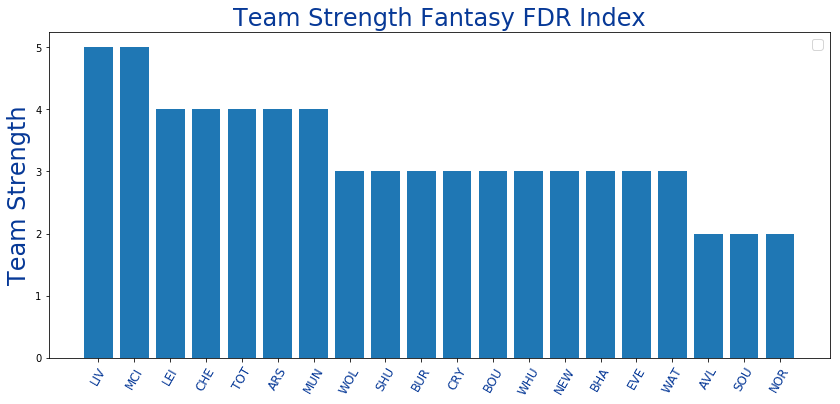

In [262]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# from pylab import rcParams
# rcParams['figure.figsize'] = 14, 6

sorted_data = sorted(scores.items(), key = lambda x: x[1], reverse = True)

Team = [item[0] for item in sorted_data]
strength = [item[1] for item in sorted_data]

plt.bar(Team, strength)
plt.ylabel('Team Strength', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Team Strength Fantasy FDR Index', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.show

In [263]:
maybs

[5.272463768115942,
 5.1,
 4.703804347826087,
 3.435144927536232,
 2.7065217391304346,
 2.721014492753623,
 2.8730072463768117,
 2.377355072463768,
 2.7293478260869564,
 2.401811594202899,
 2.1090579710144928,
 2.143478260869565,
 1.815942028985507,
 1.6362318840579708,
 2.107065217391304,
 1.8606884057971014,
 1.5778985507246377,
 0.65,
 0.7614130434782608,
 0.3478260869565215]

In [264]:
new_FDR =  list(zip(name_list, maybs))

In [265]:
new_FDR

[('LIV', 5.272463768115942),
 ('LEI', 5.1),
 ('MCI', 4.703804347826087),
 ('CHE', 3.435144927536232),
 ('TOT', 2.7065217391304346),
 ('WOL', 2.721014492753623),
 ('SHU', 2.8730072463768117),
 ('ARS', 2.377355072463768),
 ('MUN', 2.7293478260869564),
 ('BUR', 2.401811594202899),
 ('CRY', 2.1090579710144928),
 ('BOU', 2.143478260869565),
 ('WHU', 1.815942028985507),
 ('NEW', 1.6362318840579708),
 ('AVL', 2.107065217391304),
 ('BHA', 1.8606884057971014),
 ('EVE', 1.5778985507246377),
 ('SOU', 0.65),
 ('NOR', 0.7614130434782608),
 ('WAT', 0.3478260869565215)]

In [266]:
def get_avg_FDR(sorted_data, new_FDR):
    listy = []
    for item in sorted_data:
        for score in new_FDR:
            if item[0] == score[0]:
                team = item[0]
                avg_FDR = np.round((item[1] + score[1])/2, 2)
                tup = (team, avg_FDR)
                listy.append(tup)
    return listy
    

In [267]:
final_avg_FDR = get_avg_FDR(sorted_data, new_FDR)

In [268]:
final_avg_FDR = sorted(final_avg_FDR, key = lambda x: x[1], reverse = True)
final_avg_FDR

[('LIV', 5.14),
 ('MCI', 4.85),
 ('LEI', 4.55),
 ('CHE', 3.72),
 ('MUN', 3.36),
 ('TOT', 3.35),
 ('ARS', 3.19),
 ('SHU', 2.94),
 ('WOL', 2.86),
 ('BUR', 2.7),
 ('BOU', 2.57),
 ('CRY', 2.55),
 ('BHA', 2.43),
 ('WHU', 2.41),
 ('NEW', 2.32),
 ('EVE', 2.29),
 ('AVL', 2.05),
 ('WAT', 1.67),
 ('NOR', 1.38),
 ('SOU', 1.32)]

In [269]:
adjusted_FDR = dict(final_avg_FDR)

In [270]:
adjusted_FDR

{'LIV': 5.14,
 'MCI': 4.85,
 'LEI': 4.55,
 'CHE': 3.72,
 'MUN': 3.36,
 'TOT': 3.35,
 'ARS': 3.19,
 'SHU': 2.94,
 'WOL': 2.86,
 'BUR': 2.7,
 'BOU': 2.57,
 'CRY': 2.55,
 'BHA': 2.43,
 'WHU': 2.41,
 'NEW': 2.32,
 'EVE': 2.29,
 'AVL': 2.05,
 'WAT': 1.67,
 'NOR': 1.38,
 'SOU': 1.32}

No handles with labels found to put in legend.


<function matplotlib.pyplot.show(*args, **kw)>

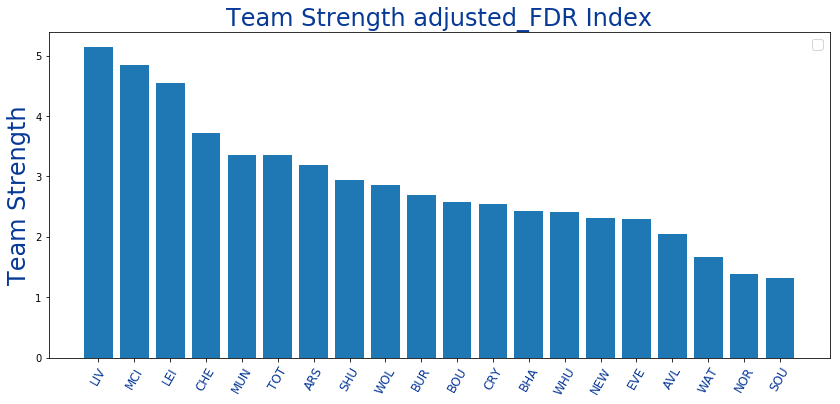

In [271]:
Team = [item[0] for item in final_avg_FDR]
strength = [item[1] for item in final_avg_FDR]

plt.bar(Team, strength)
plt.ylabel('Team Strength', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Team Strength adjusted_FDR Index', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.show

In [272]:
schedule_df.columns

Index(['Arsenal', 'Aston Villa', 'Bournemouth', 'Brighton', 'Burnley',
       'Chelsea', 'Crystal Palace', 'Everton', 'Leicester', 'Liverpool',
       'Man City', 'Man Utd', 'Newcastle', 'Norwich', 'Sheffield Utd',
       'Southampton', 'Spurs', 'Watford', 'West Ham', 'Wolves'],
      dtype='object')

In [273]:
schedule_df.head(10)

,Arsenal,Aston Villa,Bournemouth,Brighton,Burnley,Chelsea,Crystal Palace,Everton,Leicester,Liverpool,Man City,Man Utd,Newcastle,Norwich,Sheffield Utd,Southampton,Spurs,Watford,West Ham,Wolves
Gameweek,,,,,,,,,,,,,,,,,,,,
0,NEW,TOT,SHU,WAT,SOU,MUN,EVE,CRY,WOL,NOR,WHU,CHE,ARS,LIV,BOU,BUR,AVL,BHA,MCI,LEI
1,BUR,BOU,AVL,WHU,ARS,LEI,SHU,WAT,CHE,SOU,TOT,WOL,NOR,NEW,CRY,LIV,MCI,EVE,BHA,MUN
2,LIV,EVE,MCI,SOU,WOL,NOR,MUN,AVL,SHU,ARS,BOU,CRY,TOT,CHE,LEI,BHA,NEW,WHU,WAT,BUR
3,TOT,CRY,LEI,MCI,LIV,SHU,AVL,WOL,BOU,BUR,BHA,SOU,WAT,WHU,CHE,MUN,ARS,NEW,NOR,EVE
4,WAT,WHU,EVE,BUR,BHA,WOL,TOT,BOU,MUN,NEW,NOR,LEI,LIV,MCI,SOU,SHU,CRY,ARS,AVL,CHE
5,AVL,ARS,SOU,NEW,NOR,LIV,WOL,SHU,TOT,CHE,WAT,WHU,BHA,BUR,EVE,BOU,LEI,MCI,MUN,CRY
6,MUN,BUR,WHU,CHE,AVL,BHA,NOR,MCI,NEW,SHU,EVE,ARS,LEI,CRY,LIV,TOT,SOU,WOL,BOU,WAT
7,BOU,NOR,ARS,TOT,EVE,SOU,WHU,BUR,LIV,LEI,WOL,NEW,MUN,AVL,WAT,CHE,BHA,SHU,CRY,MCI
8,SHU,BHA,NOR,AVL,LEI,NEW,MCI,WHU,BUR,MUN,CRY,LIV,CHE,BOU,ARS,WOL,WAT,TOT,EVE,SOU


In [274]:
def avg_FDR(scores = adjusted_FDR, week = gameweek, periods = next_n_games):
    dic = {}
    for team in schedule_df.columns:
        oponents = schedule_df[team][(week-1):(week+periods)]
        avg_FDR = round(sum([scores[oponent] for oponent in oponents])/len(oponents), 2)
        dic[team] = avg_FDR
    return dic

In [275]:
calculate_FDR = avg_FDR()

In [276]:
sorted_FDR = sorted(calculate_FDR.items(), key=lambda x: x[1], reverse=True)

In [277]:
sorted_FDR

[('Watford', 4.08),
 ('Everton', 4.07),
 ('Bournemouth', 3.8),
 ('Aston Villa', 3.74),
 ('Burnley', 3.51),
 ('Man Utd', 3.5),
 ('Arsenal', 3.23),
 ('Man City', 3.08),
 ('Spurs', 2.97),
 ('Norwich', 2.94),
 ('Brighton', 2.87),
 ('Wolves', 2.73),
 ('West Ham', 2.46),
 ('Newcastle', 2.32),
 ('Chelsea', 2.3),
 ('Crystal Palace', 2.22),
 ('Liverpool', 2.18),
 ('Southampton', 2.04),
 ('Sheffield Utd', 1.92),
 ('Leicester', 1.7)]

<function matplotlib.pyplot.show(*args, **kw)>

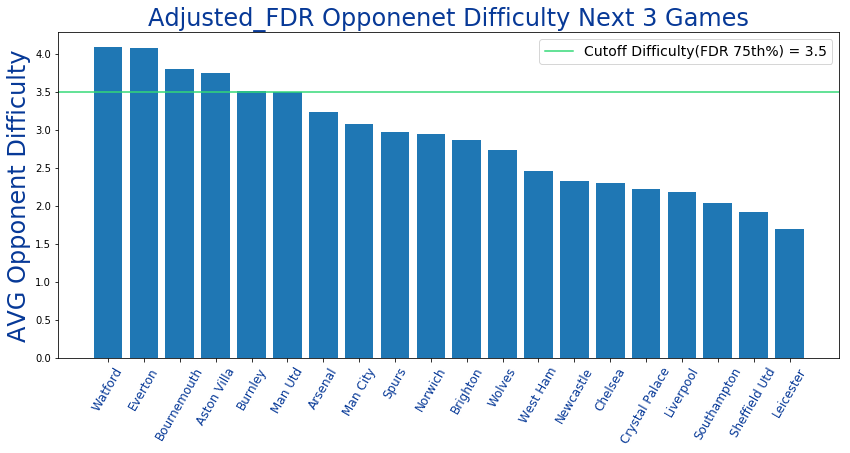

In [278]:
rcParams['figure.figsize'] = 14, 6

Team = [item[0] for item in sorted_FDR]
FDR = [item[1] for item in sorted_FDR]

FDR_75 = round(np.percentile([item[1] for item in sorted_FDR], 75), 2)
cutoff = FDR_75

plt.bar(Team, FDR)
plt.axhline(y=cutoff, linestyle='-', color='#33D977', label='Cutoff Difficulty(FDR 75th%) = ' + str(cutoff))
plt.ylabel('AVG Opponent Difficulty', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Adjusted_FDR Opponenet Difficulty Next ' + str(next_n_games +1) + ' Games', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.savefig('FDR', bbox_inches = 'tight')
plt.show

## Clean final list of available players by FDR score <= 3.56 and status = 'available'

In [279]:
player_df.head()

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
396,10,5.0,1228,John Lundstram,Defender,5.49,0,15.00,available,49,Sheffield Utd,75,2807033,294366
98,11,4.7,1260,Mathew Ryan,Goalkeeper,4.28,0,12.77,available,36,Brighton,60,751333,450883
226,5,5.0,1260,Çaglar Söyüncü,Defender,4.50,0,12.60,available,13,Leicester,63,1391481,213154
376,5,4.6,1005,Todd Cantwell,Midfielder,5.10,0,12.39,available,45,Norwich,57,2293397,1271255
393,3,4.6,1260,George Baldock,Defender,4.00,0,12.17,available,49,Sheffield Utd,56,242623,48061


In [280]:
player_df.shape

(564, 14)

In [281]:
clean_df = player_df[player_df.status == 'available']

In [282]:
clean_df.status.value_counts()

available    431
Name: status, dtype: int64

## Remove teams with FDR scores > 3.56 from DF - optional

In [283]:
teams_low_FDR = [key for (key,value) in calculate_FDR.items() if value <= cutoff]

In [284]:
teams_low_FDR

['Arsenal',
 'Brighton',
 'Chelsea',
 'Crystal Palace',
 'Leicester',
 'Liverpool',
 'Man City',
 'Man Utd',
 'Newcastle',
 'Norwich',
 'Sheffield Utd',
 'Southampton',
 'Spurs',
 'West Ham',
 'Wolves']

In [285]:
clean_df.head()

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
396,10,5.0,1228,John Lundstram,Defender,5.49,0,15.00,available,49,Sheffield Utd,75,2807033,294366
98,11,4.7,1260,Mathew Ryan,Goalkeeper,4.28,0,12.77,available,36,Brighton,60,751333,450883
226,5,5.0,1260,Çaglar Söyüncü,Defender,4.50,0,12.60,available,13,Leicester,63,1391481,213154
376,5,4.6,1005,Todd Cantwell,Midfielder,5.10,0,12.39,available,45,Norwich,57,2293397,1271255
393,3,4.6,1260,George Baldock,Defender,4.00,0,12.17,available,49,Sheffield Utd,56,242623,48061


In [286]:
final_df = clean_df.loc[clean_df.team_name.isin(teams_low_FDR)]

In [287]:
final_df.head(15)

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
396,10,5.0,1228,John Lundstram,Defender,5.49,0,15.00,available,49,Sheffield Utd,75,2807033,294366
98,11,4.7,1260,Mathew Ryan,Goalkeeper,4.28,0,12.77,available,36,Brighton,60,751333,450883
226,5,5.0,1260,Çaglar Söyüncü,Defender,4.50,0,12.60,available,13,Leicester,63,1391481,213154
376,5,4.6,1005,Todd Cantwell,Midfielder,5.10,0,12.39,available,45,Norwich,57,2293397,1271255
393,3,4.6,1260,George Baldock,Defender,4.00,0,12.17,available,49,Sheffield Utd,56,242623,48061
93,9,4.6,1170,Lewis Dunk,Defender,4.30,0,12.17,available,36,Brighton,56,724812,530633
222,9,6.4,1260,Ricardo Domingos Barbosa Pereira,Defender,5.35,0,11.72,available,13,Leicester,75,997439,346433
409,2,4.7,1170,Dean Henderson,Goalkeeper,4.15,0,11.49,available,49,Sheffield Utd,54,466374,170956
230,1,5.3,1260,Kasper Schmeichel,Goalkeeper,4.28,0,11.32,available,13,Leicester,60,688730,244230
228,19,9.8,1260,Jamie Vardy,Forward,7.85,0,11.22,available,13,Leicester,110,2994197,580867


In [288]:
clean_players = final_df.to_dict('records')

In [289]:
clean_players[:2]

[{'bonus': 10,
  'cost': 5.0,
  'minutes': 1228,
  'name': 'John Lundstram',
  'position': 'Defender',
  'pts_per_90min': 5.49,
  'red_cards': 0,
  'roi': 15.0,
  'status': 'available',
  'team_code': 49,
  'team_name': 'Sheffield Utd',
  'total_points': 75,
  'transfers_in': 2807033,
  'transfers_out': 294366},
 {'bonus': 11,
  'cost': 4.7,
  'minutes': 1260,
  'name': 'Mathew Ryan',
  'position': 'Goalkeeper',
  'pts_per_90min': 4.28,
  'red_cards': 0,
  'roi': 12.77,
  'status': 'available',
  'team_code': 36,
  'team_name': 'Brighton',
  'total_points': 60,
  'transfers_in': 751333,
  'transfers_out': 450883}]

## Get list of players by ROI, Total Points and Points Per 90 min

In [290]:
players_roi = sorted(clean_players, key = lambda x: x['roi'], reverse = True)

In [291]:
players_roi[:3]

[{'bonus': 10,
  'cost': 5.0,
  'minutes': 1228,
  'name': 'John Lundstram',
  'position': 'Defender',
  'pts_per_90min': 5.49,
  'red_cards': 0,
  'roi': 15.0,
  'status': 'available',
  'team_code': 49,
  'team_name': 'Sheffield Utd',
  'total_points': 75,
  'transfers_in': 2807033,
  'transfers_out': 294366},
 {'bonus': 11,
  'cost': 4.7,
  'minutes': 1260,
  'name': 'Mathew Ryan',
  'position': 'Goalkeeper',
  'pts_per_90min': 4.28,
  'red_cards': 0,
  'roi': 12.77,
  'status': 'available',
  'team_code': 36,
  'team_name': 'Brighton',
  'total_points': 60,
  'transfers_in': 751333,
  'transfers_out': 450883},
 {'bonus': 5,
  'cost': 5.0,
  'minutes': 1260,
  'name': 'Çaglar Söyüncü',
  'position': 'Defender',
  'pts_per_90min': 4.5,
  'red_cards': 0,
  'roi': 12.6,
  'status': 'available',
  'team_code': 13,
  'team_name': 'Leicester',
  'total_points': 63,
  'transfers_in': 1391481,
  'transfers_out': 213154}]

### Total Points

In [292]:
players_max_pts = sorted(players_roi, key = lambda x: x['total_points'], reverse = True)

In [293]:
players_max_pts[:3]

[{'bonus': 19,
  'cost': 9.8,
  'minutes': 1260,
  'name': 'Jamie Vardy',
  'position': 'Forward',
  'pts_per_90min': 7.85,
  'red_cards': 0,
  'roi': 11.22,
  'status': 'available',
  'team_code': 13,
  'team_name': 'Leicester',
  'total_points': 110,
  'transfers_in': 2994197,
  'transfers_out': 580867},
 {'bonus': 13,
  'cost': 12.2,
  'minutes': 1146,
  'name': 'Sadio Mané',
  'position': 'Midfielder',
  'pts_per_90min': 7.38,
  'red_cards': 0,
  'roi': 7.7,
  'status': 'available',
  'team_code': 14,
  'team_name': 'Liverpool',
  'total_points': 94,
  'transfers_in': 2535594,
  'transfers_out': 811418},
 {'bonus': 13,
  'cost': 10.2,
  'minutes': 1053,
  'name': 'Kevin De Bruyne',
  'position': 'Midfielder',
  'pts_per_90min': 7.94,
  'red_cards': 0,
  'roi': 9.12,
  'status': 'available',
  'team_code': 43,
  'team_name': 'Man City',
  'total_points': 93,
  'transfers_in': 3179629,
  'transfers_out': 1652560}]

### Per 90 mins played

In [294]:
players_90min = sorted(players_roi, key = lambda x: x['pts_per_90min'], reverse = True)

#define filter of minimum time played
min_min = min_min
players_90min = [player for player in players_90min if player['minutes'] >= min_min]

In [295]:
players_90min[:3]

[{'bonus': 9,
  'cost': 5.1,
  'minutes': 500,
  'name': 'Lys Mousset',
  'position': 'Forward',
  'pts_per_90min': 9.52,
  'red_cards': 0,
  'roi': 10.39,
  'status': 'available',
  'team_code': 49,
  'team_name': 'Sheffield Utd',
  'total_points': 53,
  'transfers_in': 364644,
  'transfers_out': 77083},
 {'bonus': 9,
  'cost': 8.3,
  'minutes': 615,
  'name': 'Riyad Mahrez',
  'position': 'Midfielder',
  'pts_per_90min': 8.47,
  'red_cards': 0,
  'roi': 6.99,
  'status': 'available',
  'team_code': 43,
  'team_name': 'Man City',
  'total_points': 58,
  'transfers_in': 805721,
  'transfers_out': 785882},
 {'bonus': 13,
  'cost': 10.2,
  'minutes': 1053,
  'name': 'Kevin De Bruyne',
  'position': 'Midfielder',
  'pts_per_90min': 7.94,
  'red_cards': 0,
  'roi': 9.12,
  'status': 'available',
  'team_code': 43,
  'team_name': 'Man City',
  'total_points': 93,
  'transfers_in': 3179629,
  'transfers_out': 1652560}]

### Create player lists by position and metric we want to select by

In [296]:
GK_roi = [item for item in players_roi if item['position'] == 'Goalkeeper']
DF_roi = [item for item in players_roi if item['position'] == 'Defender']
MD_roi = [item for item in players_roi if item['position'] == 'Midfielder']
ST_roi = [item for item in players_roi if item['position'] == 'Forward']

In [297]:
GK_pts = [item for item in players_max_pts if item['position'] == 'Goalkeeper']
DF_pts = [item for item in players_max_pts if item['position'] == 'Defender']
MD_pts = [item for item in players_max_pts if item['position'] == 'Midfielder']
ST_pts = [item for item in players_max_pts if item['position'] == 'Forward']

In [298]:
GK_90min = [item for item in players_90min if item['position'] == 'Goalkeeper']
DF_90min = [item for item in players_90min if item['position'] == 'Defender']
MD_90min = [item for item in players_90min if item['position'] == 'Midfielder']
ST_90min = [item for item in players_90min if item['position'] == 'Forward']

## Start by selecting top GKs by ROI

In [299]:
#define money team as empty list and list that tracks count of players selectd per team
money_team = []
players_selected = []
teams_selected = []

#Instantiate initial count per position
#Current players selected for each position
DF_curr = 0
MD_curr = 0 
ST_curr = 0

GK_budget = budget*GK_coef
print(GK_budget)

for item in GK_roi:
    if item['cost'] <= 5.5 and item['cost'] <= GK_budget:
        money_team.append(item)
        players_selected.append(item['name'])
        teams_selected.append(item['team_name'])
        GK_budget -= item['cost']
        print('Player Selected: ' + item['name'])
        print('GK budget left: ' + str(GK_budget))

print(players_selected)
print(teams_selected)

9.5
Player Selected: Mathew Ryan
GK budget left: 4.8
Player Selected: Dean Henderson
GK budget left: 0.09999999999999964
['Mathew Ryan', 'Dean Henderson']
['Brighton', 'Sheffield Utd']


## Select Top player by points from DF, MD, ST

In [300]:
DF_budget = budget*DF_coef + GK_budget
MD_budget = budget*MD_coef
ST_budget = budget*ST_coef

print(DF_budget, MD_budget, ST_budget)

#Select Top Defender
money_team.append(DF_pts[0])
players_selected.append(DF_pts[0]['name'])
teams_selected.append(DF_pts[0]['team_name'])
DF_budget -= DF_pts[0]['cost']
DF_curr += 1
print('Player Selected: ' + DF_pts[0]['name'])
print('DF budget left: ' + str(DF_budget))

#Select Top Midfielder
money_team.append(MD_pts[0])
players_selected.append(MD_pts[0]['name'])
teams_selected.append(MD_pts[0]['team_name'])
MD_budget -= MD_pts[0]['cost']
MD_curr += 1
print('Player Selected: ' + MD_pts[0]['name'])
print('MD budget left: ' + str(MD_budget))


print(players_selected)
print(teams_selected)

28.599999999999994 36.0 26.0
Player Selected: John Lundstram
DF budget left: 23.599999999999994
Player Selected: Sadio Mané
MD budget left: 23.8
['Mathew Ryan', 'Dean Henderson', 'John Lundstram', 'Sadio Mané']
['Brighton', 'Sheffield Utd', 'Sheffield Utd', 'Liverpool']


In [301]:
ST_pts[:3]

[{'bonus': 19,
  'cost': 9.8,
  'minutes': 1260,
  'name': 'Jamie Vardy',
  'position': 'Forward',
  'pts_per_90min': 7.85,
  'red_cards': 0,
  'roi': 11.22,
  'status': 'available',
  'team_code': 13,
  'team_name': 'Leicester',
  'total_points': 110,
  'transfers_in': 2994197,
  'transfers_out': 580867},
 {'bonus': 15,
  'cost': 10.9,
  'minutes': 1260,
  'name': 'Pierre-Emerick Aubameyang',
  'position': 'Forward',
  'pts_per_90min': 6.21,
  'red_cards': 0,
  'roi': 7.98,
  'status': 'available',
  'team_code': 3,
  'team_name': 'Arsenal',
  'total_points': 87,
  'transfers_in': 1334945,
  'transfers_out': 1581991},
 {'bonus': 14,
  'cost': 8.7,
  'minutes': 1216,
  'name': 'Marcus Rashford',
  'position': 'Forward',
  'pts_per_90min': 5.84,
  'red_cards': 0,
  'roi': 9.08,
  'status': 'available',
  'team_code': 1,
  'team_name': 'Man Utd',
  'total_points': 79,
  'transfers_in': 1518461,
  'transfers_out': 1626338}]

In [302]:
#Select Top Striker

for item in ST_pts[:3]:
    if teams_selected.count(item['team_name']) < 3 and len(money_team) == 4:
            money_team.append(item)
            players_selected.append(item['name'])
            teams_selected.append(item['team_name'])
            ST_budget -= item['cost']
            ST_curr += 1
            print('Player Selected: ' + item['name'])
            print('ST budget left: ' + str(ST_budget))
    break

print(len(money_team))
print(players_selected)
print(teams_selected)

Player Selected: Jamie Vardy
ST budget left: 16.2
5
['Mathew Ryan', 'Dean Henderson', 'John Lundstram', 'Sadio Mané', 'Jamie Vardy']
['Brighton', 'Sheffield Utd', 'Sheffield Utd', 'Liverpool', 'Leicester']


In [303]:
print(DF_curr, MD_curr, ST_curr)

1 1 1


In [304]:
print(DF, MD, ST)

3 4 3


### Fill rest of team with top ROI players

In [305]:
for item in DF_roi:
    if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and item['cost'] < DF_budget and DF_curr < DF:
        money_team.append(item)
        players_selected.append(item['name'])
        teams_selected.append(item['team_name'])
        DF_budget -= item['cost']
        DF_curr += 1
        print('Player Selected: ' + item['name'])
        print('DF budget left: ' + str(DF_budget))
        print('# of DFs selected: ' + str(DF_curr))
    else:
        if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and DF_max != DF_curr and item['cost'] <= DF_budget / (DF_max - DF_curr):
            money_team.append(item)
            players_selected.append(item['name'])
            teams_selected.append(item['team_name'])
            DF_budget -= item['cost']
            DF_curr += 1
            print('Player Selected: ' + item['name'])
            print('DF budget left: ' + str(DF_budget))
            print('# of DFs selected: ' + str(DF_curr))
            
            
print(len(money_team))
print(players_selected)
print(teams_selected)                       

Player Selected: Çaglar Söyüncü
DF budget left: 18.599999999999994
# of DFs selected: 2
Player Selected: George Baldock
DF budget left: 13.999999999999995
# of DFs selected: 3
Player Selected: Lewis Dunk
DF budget left: 9.399999999999995
# of DFs selected: 4
Player Selected: Ricardo Domingos Barbosa Pereira
DF budget left: 2.9999999999999947
# of DFs selected: 5
9
['Mathew Ryan', 'Dean Henderson', 'John Lundstram', 'Sadio Mané', 'Jamie Vardy', 'Çaglar Söyüncü', 'George Baldock', 'Lewis Dunk', 'Ricardo Domingos Barbosa Pereira']
['Brighton', 'Sheffield Utd', 'Sheffield Utd', 'Liverpool', 'Leicester', 'Leicester', 'Sheffield Utd', 'Brighton', 'Leicester']


## Fill MD position

In [306]:
#move leftover DF budget to MD budget
MD_budget += DF_budget

for item in MD_roi:
    if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and item['cost'] < MD_budget and MD_curr < MD:
        money_team.append(item)
        players_selected.append(item['name'])
        teams_selected.append(item['team_name'])
        MD_budget -= item['cost']
        MD_curr += 1
        print('Player Selected: ' + item['name'])
        print('MD budget left: ' + str(MD_budget))
    else:
        if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and MD_max != MD_curr and item['cost'] <= MD_budget / (MD_max - MD_curr):
            money_team.append(item)
            players_selected.append(item['name'])
            teams_selected.append(item['team_name'])
            MD_budget -= item['cost']
            MD_curr += 1
            print('Player Selected: ' + item['name'])
            print('MD budget left: ' + str(MD_budget))
            
            
print(len(money_team))
print(players_selected)
print(teams_selected) 

Player Selected: Todd Cantwell
MD budget left: 22.199999999999996
Player Selected: Adama Traoré
MD budget left: 16.999999999999996
Player Selected: James Ward-Prowse
MD budget left: 11.199999999999996
Player Selected: Kevin De Bruyne
MD budget left: 0.9999999999999964
13
['Mathew Ryan', 'Dean Henderson', 'John Lundstram', 'Sadio Mané', 'Jamie Vardy', 'Çaglar Söyüncü', 'George Baldock', 'Lewis Dunk', 'Ricardo Domingos Barbosa Pereira', 'Todd Cantwell', 'Adama Traoré', 'James Ward-Prowse', 'Kevin De Bruyne']
['Brighton', 'Sheffield Utd', 'Sheffield Utd', 'Liverpool', 'Leicester', 'Leicester', 'Sheffield Utd', 'Brighton', 'Leicester', 'Norwich', 'Wolves', 'Southampton', 'Man City']


## Fill ST position

In [307]:
#move leftover MD budget to ST budget
ST_budget += MD_budget

for item in ST_roi:
    if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and item['cost'] < ST_budget and ST_curr < ST:
        money_team.append(item)
        players_selected.append(item['name'])
        teams_selected.append(item['team_name'])
        ST_budget -= item['cost']
        ST_curr += 1
        print('Player Selected: ' + item['name'])
        print('ST budget left: ' + str(ST_budget))
    else:
        if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and ST_max != ST_curr and item['cost'] <= ST_budget / (ST_max - ST_curr):
            money_team.append(item)
            players_selected.append(item['name'])
            teams_selected.append(item['team_name'])
            ST_budget -= item['cost']
            ST_curr += 1
            print('Player Selected: ' + item['name'])
            print('ST budget left: ' + str(ST_budget))
            
            
print(len(money_team))
print(players_selected)
print(teams_selected) 

Player Selected: Teemu Pukki
ST budget left: 10.599999999999996
Player Selected: Danny Ings
ST budget left: 4.4999999999999964
15
['Mathew Ryan', 'Dean Henderson', 'John Lundstram', 'Sadio Mané', 'Jamie Vardy', 'Çaglar Söyüncü', 'George Baldock', 'Lewis Dunk', 'Ricardo Domingos Barbosa Pereira', 'Todd Cantwell', 'Adama Traoré', 'James Ward-Prowse', 'Kevin De Bruyne', 'Teemu Pukki', 'Danny Ings']
['Brighton', 'Sheffield Utd', 'Sheffield Utd', 'Liverpool', 'Leicester', 'Leicester', 'Sheffield Utd', 'Brighton', 'Leicester', 'Norwich', 'Wolves', 'Southampton', 'Man City', 'Norwich', 'Southampton']


In [308]:
money_df = pd.DataFrame(money_team)

In [309]:
money_df

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
0,11,4.7,1260,Mathew Ryan,Goalkeeper,4.28,0,12.77,available,36,Brighton,60,751333,450883
1,2,4.7,1170,Dean Henderson,Goalkeeper,4.15,0,11.49,available,49,Sheffield Utd,54,466374,170956
2,10,5.0,1228,John Lundstram,Defender,5.49,0,15.00,available,49,Sheffield Utd,75,2807033,294366
3,13,12.2,1146,Sadio Mané,Midfielder,7.38,0,7.70,available,14,Liverpool,94,2535594,811418
4,19,9.8,1260,Jamie Vardy,Forward,7.85,0,11.22,available,13,Leicester,110,2994197,580867
5,5,5.0,1260,Çaglar Söyüncü,Defender,4.50,0,12.60,available,13,Leicester,63,1391481,213154
6,3,4.6,1260,George Baldock,Defender,4.00,0,12.17,available,49,Sheffield Utd,56,242623,48061
7,9,4.6,1170,Lewis Dunk,Defender,4.30,0,12.17,available,36,Brighton,56,724812,530633
8,9,6.4,1260,Ricardo Domingos Barbosa Pereira,Defender,5.35,0,11.72,available,13,Leicester,75,997439,346433
9,5,4.6,1005,Todd Cantwell,Midfielder,5.10,0,12.39,available,45,Norwich,57,2293397,1271255


<function matplotlib.pyplot.show(*args, **kw)>

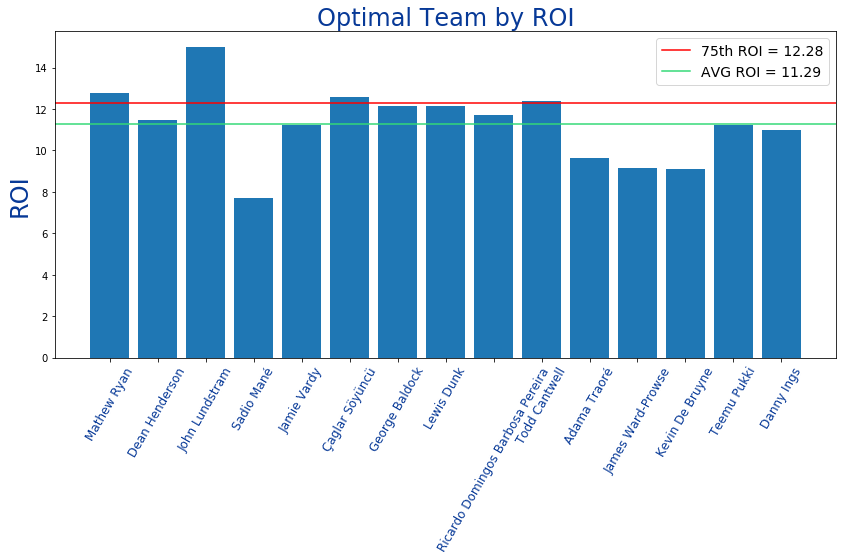

In [310]:
money_x = money_df.roi
money_y = money_df.name
ST_75th = round(money_df.describe().roi['75%'], 2)
ST_AVG = round(money_df.describe().roi['mean'], 2)

plt.bar(money_y, money_x)
plt.axhline(y=ST_75th, color='r', linestyle='-', label='75th ROI = ' + str(ST_75th))
plt.axhline(y=ST_AVG, color='#33D977', linestyle='-', label='AVG ROI = ' + str(ST_AVG))
plt.ylabel('ROI', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Optimal Team by ROI', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.show

### Top 10 ROI players by position

In [311]:
GK_df = pd.DataFrame(GK_roi)
GK_df.head(10)

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
0,11,4.7,1260,Mathew Ryan,Goalkeeper,4.28,0,12.77,available,36,Brighton,60,751333,450883
1,2,4.7,1170,Dean Henderson,Goalkeeper,4.15,0,11.49,available,49,Sheffield Utd,54,466374,170956
2,1,5.3,1260,Kasper Schmeichel,Goalkeeper,4.28,0,11.32,available,13,Leicester,60,688730,244230
3,6,4.5,1080,Tim Krul,Goalkeeper,4.08,0,10.89,available,45,Norwich,49,111826,76723
4,4,5.2,1260,Rui Pedro dos Santos Patrício,Goalkeeper,3.85,0,10.38,available,39,Wolves,54,769976,375311
5,3,5.0,1260,Bernd Leno,Goalkeeper,3.43,0,9.60,available,3,Arsenal,48,331936,328024
6,2,5.0,1260,Martin Dubravka,Goalkeeper,3.35,0,9.40,available,4,Newcastle,47,40985,47572
7,3,5.0,1080,Vicente Guaita,Goalkeeper,3.58,0,8.60,available,31,Crystal Palace,43,55402,48666
8,5,5.5,1260,David de Gea,Goalkeeper,3.21,0,8.18,available,1,Man Utd,45,793086,856577
9,2,6.0,1170,Ederson Santana de Moraes,Goalkeeper,3.69,0,8.00,available,43,Man City,48,787993,1060117


In [312]:
DF_df = pd.DataFrame(DF_roi)
DF_df.head(10)

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
0,10,5.0,1228,John Lundstram,Defender,5.49,0,15.00,available,49,Sheffield Utd,75,2807033,294366
1,5,5.0,1260,Çaglar Söyüncü,Defender,4.50,0,12.60,available,13,Leicester,63,1391481,213154
2,3,4.6,1260,George Baldock,Defender,4.00,0,12.17,available,49,Sheffield Utd,56,242623,48061
3,9,4.6,1170,Lewis Dunk,Defender,4.30,0,12.17,available,36,Brighton,56,724812,530633
4,9,6.4,1260,Ricardo Domingos Barbosa Pereira,Defender,5.35,0,11.72,available,13,Leicester,75,997439,346433
5,6,4.6,923,Jetro Willems,Defender,4.87,0,10.87,available,4,Newcastle,50,177085,53159
6,3,5.9,1080,Benjamin Chilwell,Defender,5.33,0,10.85,available,13,Leicester,64,928301,274009
7,4,5.1,1231,Jonny Evans,Defender,4.02,0,10.78,available,13,Leicester,55,229053,108871
8,4,4.6,1260,Jack O'Connell,Defender,3.50,0,10.65,available,49,Sheffield Utd,49,151930,48476
9,4,5.1,1260,Enda Stevens,Defender,3.78,0,10.39,available,49,Sheffield Utd,53,200042,68101


In [313]:
MD_df = pd.DataFrame(MD_roi)
MD_df.head(10)

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
0,5,4.6,1005,Todd Cantwell,Midfielder,5.10,0,12.39,available,45,Norwich,57,2293397,1271255
1,6,5.2,1010,Adama Traoré,Midfielder,4.45,0,9.62,available,39,Wolves,50,477008,176481
2,4,6.7,1251,Youri Tielemans,Midfielder,4.46,0,9.25,available,13,Leicester,62,780817,424630
3,6,5.8,1260,James Ward-Prowse,Midfielder,3.78,0,9.14,available,20,Southampton,53,79302,65489
4,13,10.2,1053,Kevin De Bruyne,Midfielder,7.94,0,9.12,available,43,Man City,93,3179629,1652560
5,6,6.7,1144,Mason Mount,Midfielder,4.79,0,9.10,available,8,Chelsea,61,3303258,1511334
6,7,5.3,1169,João Filipe Iria Santos Moutinho,Midfielder,3.69,0,9.06,available,39,Wolves,48,255185,379874
7,2,6.2,831,Ayoze Pérez,Midfielder,6.06,0,9.03,available,13,Leicester,56,483592,978173
8,7,7.6,830,David Silva,Midfielder,7.36,0,8.95,available,43,Man City,68,1142752,977223
9,8,7.6,1142,James Maddison,Midfielder,5.28,0,8.82,available,13,Leicester,67,1736356,711262


In [314]:
ST_df = pd.DataFrame(ST_roi)
ST_df.head(10)

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
0,19,9.8,1260,Jamie Vardy,Forward,7.85,0,11.22,available,13,Leicester,110,2994197,580867
1,11,6.6,1245,Teemu Pukki,Forward,5.35,0,11.21,available,45,Norwich,74,3347133,2658789
2,13,6.1,911,Danny Ings,Forward,6.61,0,10.98,available,20,Southampton,67,620487,264119
3,9,5.1,500,Lys Mousset,Forward,9.52,0,10.39,available,49,Sheffield Utd,53,364644,77083
4,11,5.1,1032,Jordan Ayew,Forward,4.36,0,9.80,available,31,Crystal Palace,50,942941,631118
5,14,7.7,1212,Raúl Jiménez,Forward,5.42,0,9.48,available,39,Wolves,73,1398635,1263472
6,14,8.7,1216,Marcus Rashford,Forward,5.84,0,9.08,available,1,Man Utd,79,1518461,1626338
7,15,10.9,1260,Pierre-Emerick Aubameyang,Forward,6.21,0,7.98,available,3,Arsenal,87,1334945,1581991
8,7,5.9,974,Neal Maupay,Forward,4.34,0,7.97,available,36,Brighton,47,186034,153379
9,5,7.1,1094,Sébastien Haller,Forward,4.19,0,7.18,available,21,West Ham,51,534714,625061


## Define Clean df for graphing purposes

In [315]:
clean_df.head()

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
396,10,5.0,1228,John Lundstram,Defender,5.49,0,15.00,available,49,Sheffield Utd,75,2807033,294366
98,11,4.7,1260,Mathew Ryan,Goalkeeper,4.28,0,12.77,available,36,Brighton,60,751333,450883
226,5,5.0,1260,Çaglar Söyüncü,Defender,4.50,0,12.60,available,13,Leicester,63,1391481,213154
376,5,4.6,1005,Todd Cantwell,Midfielder,5.10,0,12.39,available,45,Norwich,57,2293397,1271255
393,3,4.6,1260,George Baldock,Defender,4.00,0,12.17,available,49,Sheffield Utd,56,242623,48061


In [316]:
graph_roi = []
for row, player in clean_df.iterrows():
    playa = dict(name = player['name'], position = player.position, team=player.team_name, cost = player.cost, points = player.total_points, minutes = player.minutes, ROI = player.roi, pts_per_90min = player.pts_per_90min)
    graph_roi.append(playa)

In [317]:
graph_roi[:3]

[{'name': 'John Lundstram',
  'position': 'Defender',
  'team': 'Sheffield Utd',
  'cost': 5.0,
  'points': 75,
  'minutes': 1228,
  'ROI': 15.0,
  'pts_per_90min': 5.49},
 {'name': 'Mathew Ryan',
  'position': 'Goalkeeper',
  'team': 'Brighton',
  'cost': 4.7,
  'points': 60,
  'minutes': 1260,
  'ROI': 12.77,
  'pts_per_90min': 4.28},
 {'name': 'Çaglar Söyüncü',
  'position': 'Defender',
  'team': 'Leicester',
  'cost': 5.0,
  'points': 63,
  'minutes': 1260,
  'ROI': 12.6,
  'pts_per_90min': 4.5}]

### Graph by ROI

In [318]:
GK_graph = clean_df[clean_df['position'] == 'Goalkeeper']
DF_graph = clean_df[clean_df['position'] == 'Defender']
MD_graph = clean_df[clean_df['position'] == 'Midfielder']
ST_graph = clean_df[clean_df['position'] == 'Forward']

### Graph by 90_min Stat

In [319]:
sorted_players_90min = sorted(graph_roi, key = lambda x: x['pts_per_90min'], reverse = True)

#define filter of minimum time played
min_min = min_min
sorted_players_90min = [player for player in sorted_players_90min if player['minutes'] >= min_min]

In [320]:
sorted_players_90min[:3]

[{'name': 'Lys Mousset',
  'position': 'Forward',
  'team': 'Sheffield Utd',
  'cost': 5.1,
  'points': 53,
  'minutes': 500,
  'ROI': 10.39,
  'pts_per_90min': 9.52},
 {'name': 'Riyad Mahrez',
  'position': 'Midfielder',
  'team': 'Man City',
  'cost': 8.3,
  'points': 58,
  'minutes': 615,
  'ROI': 6.99,
  'pts_per_90min': 8.47},
 {'name': 'Kevin De Bruyne',
  'position': 'Midfielder',
  'team': 'Man City',
  'cost': 10.2,
  'points': 93,
  'minutes': 1053,
  'ROI': 9.12,
  'pts_per_90min': 7.94}]

In [321]:
df_90min = pd.DataFrame(sorted_players_90min)

In [322]:
df_90min.head()

,ROI,cost,minutes,name,points,position,pts_per_90min,team
0,10.39,5.1,500,Lys Mousset,53,Forward,9.52,Sheffield Utd
1,6.99,8.3,615,Riyad Mahrez,58,Midfielder,8.47,Man City
2,9.12,10.2,1053,Kevin De Bruyne,93,Midfielder,7.94,Man City
3,11.22,9.8,1260,Jamie Vardy,110,Forward,7.85,Leicester
4,7.70,12.2,1146,Sadio Mané,94,Midfielder,7.38,Liverpool


In [323]:
GK_90min_graph = df_90min[df_90min['position'] == 'Goalkeeper']
DF_90min_graph = df_90min[df_90min['position'] == 'Defender']
MD_90min_graph = df_90min[df_90min['position'] == 'Midfielder']
ST_90min_graph = df_90min[df_90min['position'] == 'Forward']

In [324]:
GK_90min_graph.head()

,ROI,cost,minutes,name,points,position,pts_per_90min,team
68,12.77,4.7,1260,Mathew Ryan,60,Goalkeeper,4.28,Brighton
69,11.32,5.3,1260,Kasper Schmeichel,60,Goalkeeper,4.28,Leicester
76,11.49,4.7,1170,Dean Henderson,54,Goalkeeper,4.15,Sheffield Utd
79,10.89,4.5,1080,Tim Krul,49,Goalkeeper,4.08,Norwich
89,11.70,4.7,1260,Aaron Ramsdale,55,Goalkeeper,3.93,Bournemouth


In [325]:
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 14, 6

## Top 10 Keepers ROI

<function matplotlib.pyplot.show(*args, **kw)>

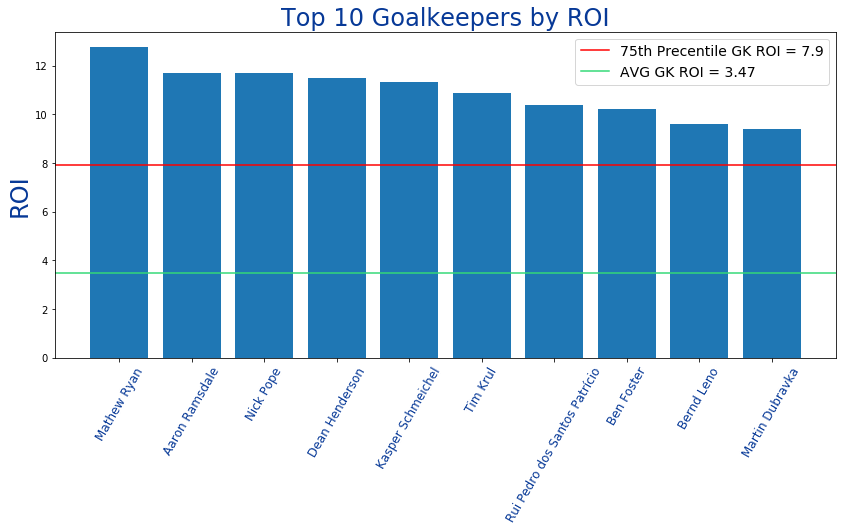

In [326]:
GK_x = GK_graph[:10].roi
GK_y = GK_graph[:10].name
GK_75th = round(GK_graph.describe().roi['75%'], 2)
GK_AVG = round(GK_graph.describe().roi['mean'], 2)

plt.bar(GK_y, GK_x)
plt.axhline(y=GK_75th, color='r', linestyle='-', label='75th Precentile GK ROI = ' + str(GK_75th))
plt.axhline(y=GK_AVG, color='#33D977', linestyle='-', label='AVG GK ROI = ' + str(GK_AVG))
plt.ylabel('ROI', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 10 Goalkeepers by ROI', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.savefig('GK_ROI', bbox_inches = 'tight')
plt.show

## Top 10 Keepers 90_min

<function matplotlib.pyplot.show(*args, **kw)>

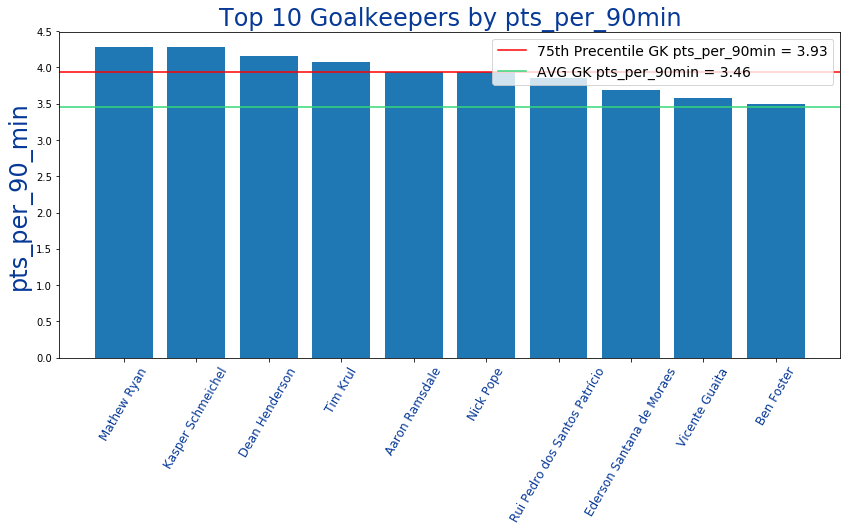

In [327]:
GK_x = GK_90min_graph[:10].pts_per_90min
GK_y = GK_90min_graph[:10].name
GK_75th = round(GK_90min_graph.describe().pts_per_90min['75%'], 2)
GK_AVG = round(GK_90min_graph.describe().pts_per_90min['mean'], 2)

plt.bar(GK_y, GK_x)
plt.axhline(y=GK_75th, color='r', linestyle='-', label='75th Precentile GK pts_per_90min = ' + str(GK_75th))
plt.axhline(y=GK_AVG, color='#33D977', linestyle='-', label='AVG GK pts_per_90min = ' + str(GK_AVG))
plt.ylabel('pts_per_90_min', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 10 Goalkeepers by pts_per_90min', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.savefig('GK_90min', bbox_inches = 'tight')
plt.show

## Top 10 Defenders

<function matplotlib.pyplot.show(*args, **kw)>

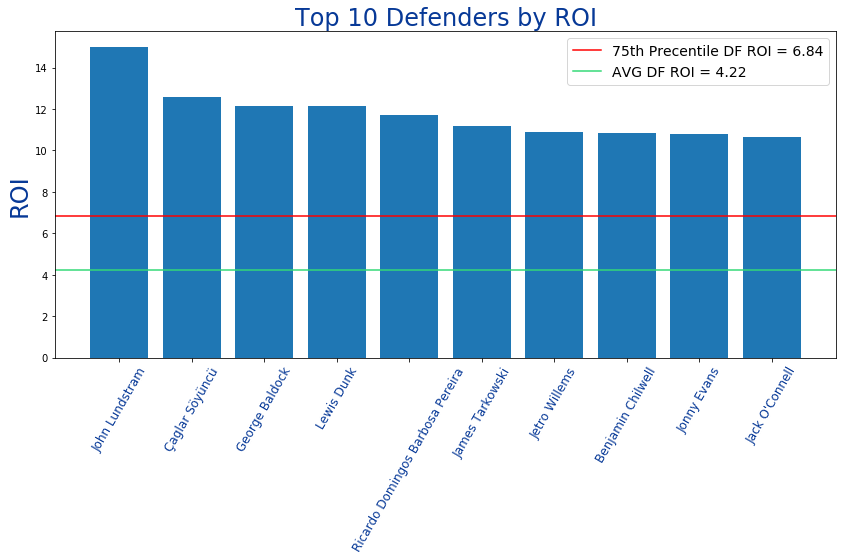

In [328]:
DF_x = DF_graph[:10].roi
DF_y = DF_graph[:10].name
DF_75th = round(DF_graph.describe().roi['75%'], 2)
DF_AVG = round(DF_graph.describe().roi['mean'], 2)

plt.bar(DF_y, DF_x)
plt.axhline(y=DF_75th, color='r', linestyle='-', label='75th Precentile DF ROI = ' + str(DF_75th))
plt.axhline(y=DF_AVG, color='#33D977', linestyle='-', label='AVG DF ROI = ' + str(DF_AVG))
plt.ylabel('ROI', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 10 Defenders by ROI', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.savefig('DF_ROI', bbox_inches = 'tight')
plt.show

## Top 10 Defenders 90min Stat

<function matplotlib.pyplot.show(*args, **kw)>

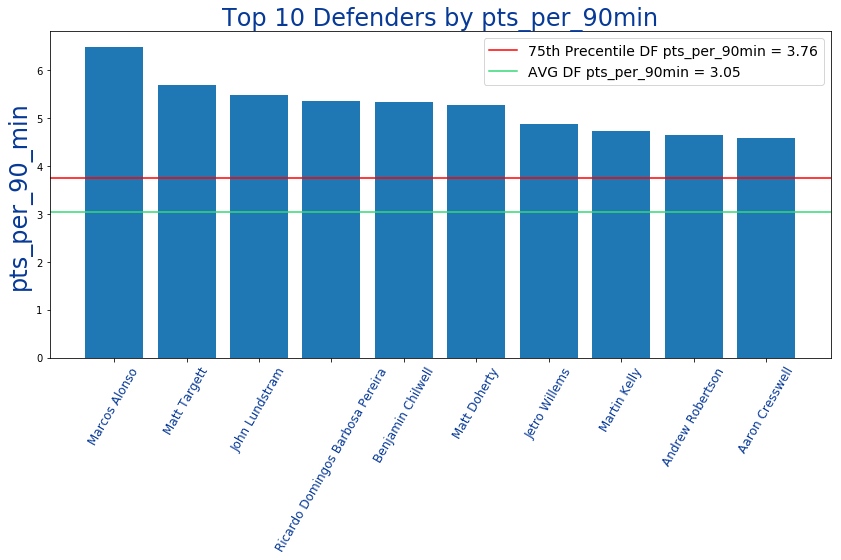

In [329]:
DF_x = DF_90min_graph[:10].pts_per_90min
DF_y = DF_90min_graph[:10].name
DF_75th = round(DF_90min_graph.describe().pts_per_90min['75%'], 2)
DF_AVG = round(DF_90min_graph.describe().pts_per_90min['mean'], 2)

plt.bar(DF_y, DF_x)
plt.axhline(y=DF_75th, color='r', linestyle='-', label='75th Precentile DF pts_per_90min = ' + str(DF_75th))
plt.axhline(y=DF_AVG, color='#33D977', linestyle='-', label='AVG DF pts_per_90min = ' + str(DF_AVG))
plt.ylabel('pts_per_90_min', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 10 Defenders by pts_per_90min', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.savefig('DF_90min', bbox_inches = 'tight')
plt.show

## Top 10 Midfielders

<function matplotlib.pyplot.show(*args, **kw)>

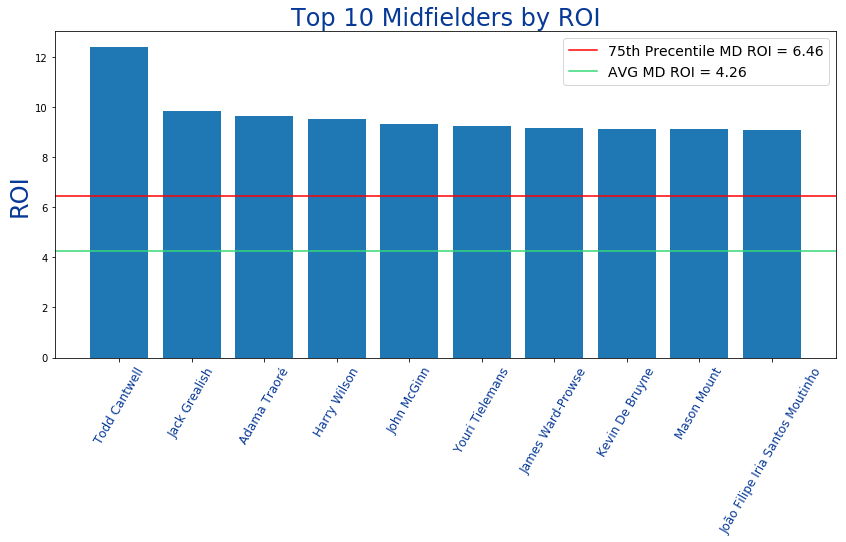

In [330]:
MD_x = MD_graph[:10].roi
MD_y = MD_graph[:10].name
MD_75th = round(MD_graph.describe().roi['75%'], 2)
MD_AVG = round(MD_graph.describe().roi['mean'], 2)

plt.bar(MD_y, MD_x)
plt.axhline(y=MD_75th, color='r', linestyle='-', label='75th Precentile MD ROI = ' + str(MD_75th))
plt.axhline(y=MD_AVG, color='#33D977', linestyle='-', label='AVG MD ROI = ' + str(MD_AVG))
plt.ylabel('ROI', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 10 Midfielders by ROI', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.savefig('MD_ROI', bbox_inches = 'tight')
plt.show

## Top 10 Midfielders 90min Stat

<function matplotlib.pyplot.show(*args, **kw)>

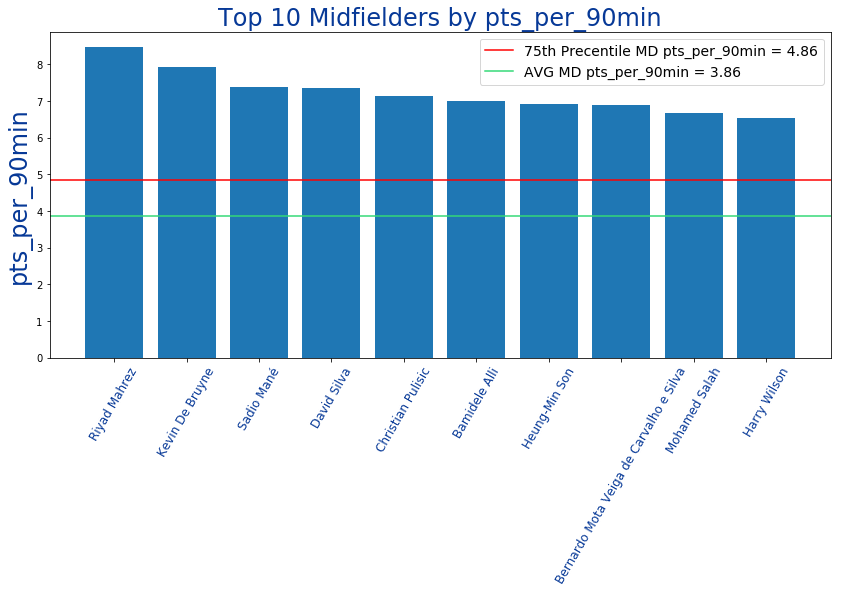

In [331]:
MD_x = MD_90min_graph[:10].pts_per_90min
MD_y = MD_90min_graph[:10].name
MD_75th = round(MD_90min_graph.describe().pts_per_90min['75%'], 2)
MD_AVG = round(MD_90min_graph.describe().pts_per_90min['mean'], 2)

plt.bar(MD_y, MD_x)
plt.axhline(y=MD_75th, color='r', linestyle='-', label='75th Precentile MD pts_per_90min = ' + str(MD_75th))
plt.axhline(y=MD_AVG, color='#33D977', linestyle='-', label='AVG MD pts_per_90min = ' + str(MD_AVG))
plt.ylabel('pts_per_90min', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 10 Midfielders by pts_per_90min', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.savefig('MD_90min', bbox_inches = 'tight')
plt.show

## Top 10 Strikers

<function matplotlib.pyplot.show(*args, **kw)>

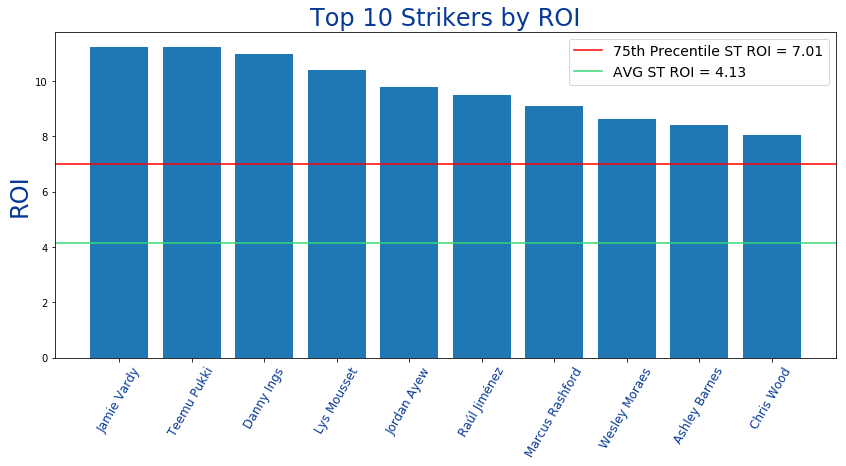

In [332]:
ST_x = ST_graph[:10].roi
ST_y = ST_graph[:10].name
ST_75th = round(ST_graph.describe().roi['75%'], 2)
ST_AVG = round(ST_graph.describe().roi['mean'], 2)

plt.bar(ST_y, ST_x)
plt.axhline(y=ST_75th, color='r', linestyle='-', label='75th Precentile ST ROI = ' + str(ST_75th))
plt.axhline(y=ST_AVG, color='#33D977', linestyle='-', label='AVG ST ROI = ' + str(ST_AVG))
plt.ylabel('ROI', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 10 Strikers by ROI', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.savefig('ST_ROI', bbox_inches = 'tight')
plt.show

## Top 10 Strikers 90min Stat

<function matplotlib.pyplot.show(*args, **kw)>

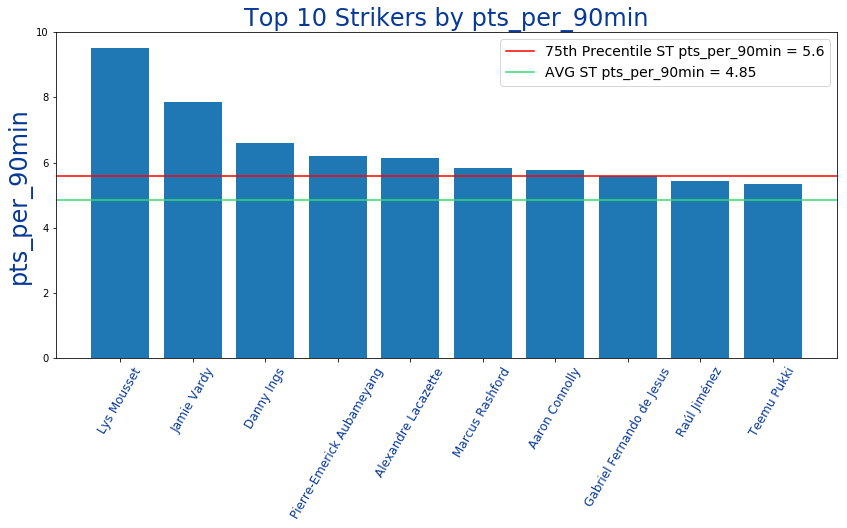

In [333]:
ST_x = ST_90min_graph[:10].pts_per_90min
ST_y = ST_90min_graph[:10].name
ST_75th = round(ST_90min_graph.describe().pts_per_90min['75%'], 2)
ST_AVG = round(ST_90min_graph.describe().pts_per_90min['mean'], 2)

plt.bar(ST_y, ST_x)
plt.axhline(y=ST_75th, color='r', linestyle='-', label='75th Precentile ST pts_per_90min = ' + str(ST_75th))
plt.axhline(y=ST_AVG, color='#33D977', linestyle='-', label='AVG ST pts_per_90min = ' + str(ST_AVG))
plt.ylabel('pts_per_90min', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 10 Strikers by pts_per_90min', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.savefig('ST_90min', bbox_inches = 'tight')
plt.show

In [334]:
team_df

,code,strength,Team,name,Played,W,L,D,GF,GA,GD,Pts
Position,,,,,,,,,,,,
1,14,5,LIV,Liverpool,14,13,0,1,32,12,+20,40
2,13,4,LEI,Leicester,14,10,2,2,33,9,+24,32
3,43,5,MCI,Man City,14,9,3,2,39,16,+23,29
4,8,4,CHE,Chelsea,14,8,4,2,28,20,+8,26
5,6,4,TOT,Spurs,14,5,4,5,24,21,+3,20
6,39,3,WOL,Wolves,14,4,2,8,19,17,+2,20
7,49,3,SHU,Sheffield Utd,14,4,3,7,17,13,+4,19
8,3,4,ARS,Arsenal,14,4,3,7,20,21,-1,19
9,1,4,MUN,Man Utd,14,4,4,6,21,17,+4,18


### Team Stats

In [335]:
teams_stats = team_df.iloc[:,2:12]

In [336]:
teams_stats.GF = [int(item) for item in teams_stats.GF]
teams_stats.GA = [int(item) for item in teams_stats.GA]

In [337]:
teams_stats

,Team,name,Played,W,L,D,GF,GA,GD,Pts
Position,,,,,,,,,,
1,LIV,Liverpool,14,13,0,1,32,12,+20,40
2,LEI,Leicester,14,10,2,2,33,9,+24,32
3,MCI,Man City,14,9,3,2,39,16,+23,29
4,CHE,Chelsea,14,8,4,2,28,20,+8,26
5,TOT,Spurs,14,5,4,5,24,21,+3,20
6,WOL,Wolves,14,4,2,8,19,17,+2,20
7,SHU,Sheffield Utd,14,4,3,7,17,13,+4,19
8,ARS,Arsenal,14,4,3,7,20,21,-1,19
9,MUN,Man Utd,14,4,4,6,21,17,+4,18


### Worst/ Best  Defence vs. Offence

In [338]:
worst_defence_df = teams_stats.sort_values(by = ['GA'], ascending = False)

In [339]:
worst_defence_df.head()

,Team,name,Played,W,L,D,GF,GA,GD,Pts
Position,,,,,,,,,,
18,SOU,Southampton,14,3,8,3,15,32,-17,12
19,NOR,Norwich,14,3,9,2,15,30,-15,11
20,WAT,Watford,14,1,8,5,9,28,-19,8
13,WHU,West Ham,14,4,6,4,17,23,-6,16
14,NEW,Newcastle,14,4,6,4,13,22,-9,16


In [340]:
best_defence_df = teams_stats.sort_values(by = ['GA'], ascending = True)

In [341]:
best_defence_df.head()

,Team,name,Played,W,L,D,GF,GA,GD,Pts
Position,,,,,,,,,,
2,LEI,Leicester,14,10,2,2,33,9,+24,32
1,LIV,Liverpool,14,13,0,1,32,12,+20,40
7,SHU,Sheffield Utd,14,4,3,7,17,13,+4,19
3,MCI,Man City,14,9,3,2,39,16,+23,29
6,WOL,Wolves,14,4,2,8,19,17,+2,20


In [342]:
GA = list(zip(worst_defence_df.name, worst_defence_df.GA))
GA_bottom5 = GA[:7]
GA_top5 = sorted(GA[-7:], key = lambda x: x[1])

In [343]:
GA_bottom5, GA_top5

([('Southampton', 32),
  ('Norwich', 30),
  ('Watford', 28),
  ('West Ham', 23),
  ('Newcastle', 22),
  ('Everton', 22),
  ('Aston Villa', 22)],
 [('Leicester', 9),
  ('Liverpool', 12),
  ('Sheffield Utd', 13),
  ('Man City', 16),
  ('Man Utd', 17),
  ('Wolves', 17),
  ('Crystal Palace', 18)])

In [344]:
teams_stats.GA.median()

20.5

<function matplotlib.pyplot.show(*args, **kw)>

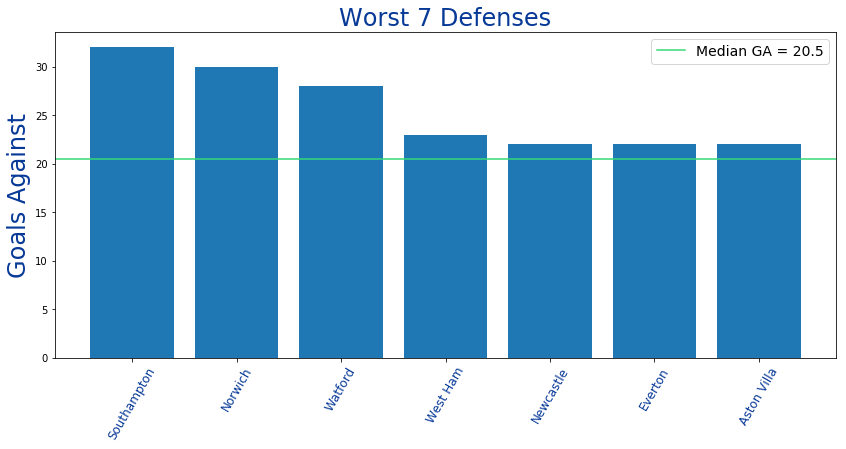

In [345]:
X = [item[0] for item in GA_bottom5]
Y = [int(item[1]) for item in GA_bottom5]

median = teams_stats.GA.median()

plt.bar(X, Y)
plt.ylim(bottom=0)
plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GA = ' + str(median))
plt.ylabel('Goals Against', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Worst 7 Defenses', fontsize = 24, color = '#073997')
plt.legend(fontsize = 14)
plt.savefig('Worst_DF', bbox_inches = 'tight')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

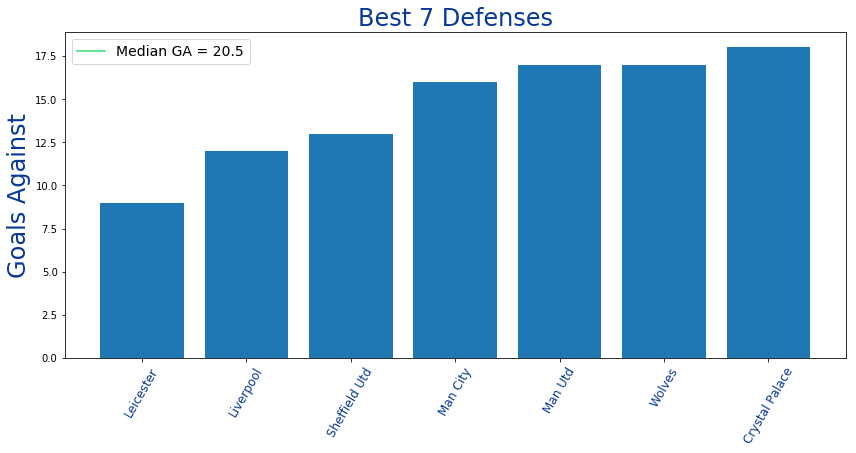

In [346]:
X = [item[0] for item in GA_top5]
Y = [int(item[1]) for item in GA_top5]

median = teams_stats.GA.median()

plt.bar(X, Y)
plt.ylim(bottom=0)
plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GA = ' + str(median))
plt.ylabel('Goals Against', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Best 7 Defenses', fontsize = 24, color = '#073997')
plt.legend(fontsize = 14)
plt.savefig('Best_DF', bbox_inches = 'tight')
plt.show

In [347]:
offense_df = teams_stats.sort_values(by = ['GF'], ascending = False)

In [348]:
offense_df.head()

,Team,name,Played,W,L,D,GF,GA,GD,Pts
Position,,,,,,,,,,
3,MCI,Man City,14,9,3,2,39,16,+23,29
2,LEI,Leicester,14,10,2,2,33,9,+24,32
1,LIV,Liverpool,14,13,0,1,32,12,+20,40
4,CHE,Chelsea,14,8,4,2,28,20,+8,26
5,TOT,Spurs,14,5,4,5,24,21,+3,20


In [349]:
GF = list(zip(offense_df.name, offense_df.GF))
GF_top5 = GF[:7]
GF_bottom5 = GF[-7:]

In [350]:
GF_top5, GF_bottom5

([('Man City', 39),
  ('Leicester', 33),
  ('Liverpool', 32),
  ('Chelsea', 28),
  ('Spurs', 24),
  ('Aston Villa', 21),
  ('Man Utd', 21)],
 [('Brighton', 16),
  ('Southampton', 15),
  ('Norwich', 15),
  ('Everton', 14),
  ('Crystal Palace', 13),
  ('Newcastle', 13),
  ('Watford', 9)])

<function matplotlib.pyplot.show(*args, **kw)>

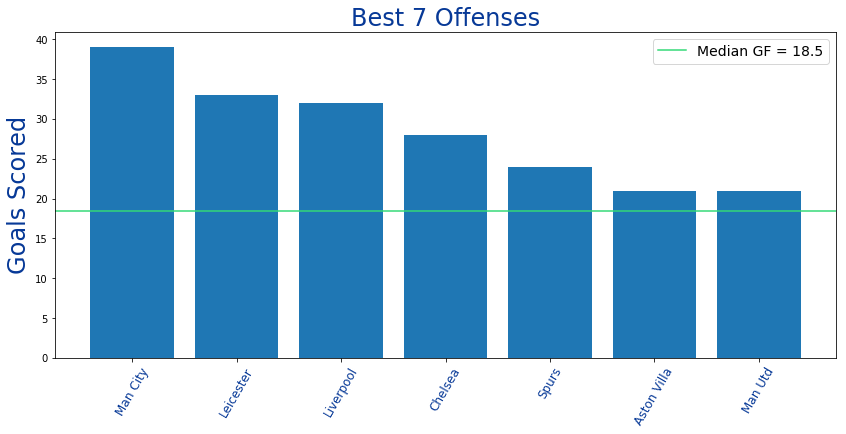

In [351]:
X = [item[0] for item in GF_top5]
Y = [int(item[1]) for item in GF_top5]

median = teams_stats.GF.median()

plt.bar(X, Y)
plt.ylim(bottom=0)
plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GF = ' + str(median))
plt.ylabel('Goals Scored', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Best 7 Offenses', fontsize = 24, color = '#073997')
plt.legend(fontsize = 14)
plt.savefig('Best_Offense', bbox_inches = 'tight')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

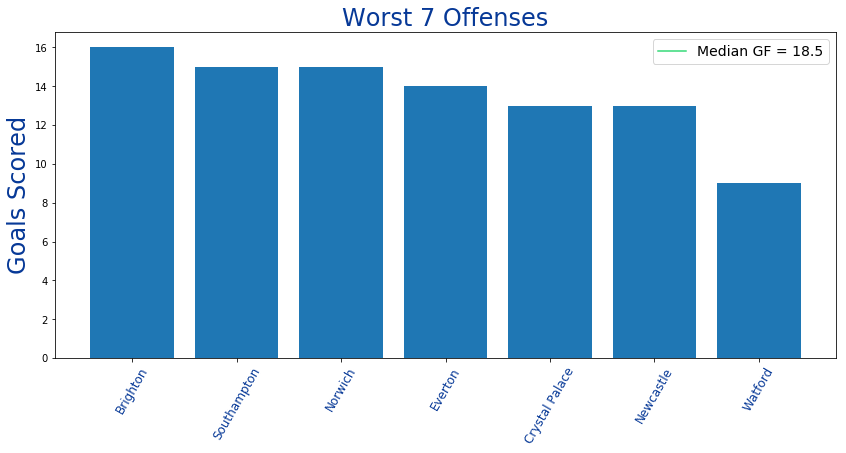

In [352]:
X = [item[0] for item in GF_bottom5]
Y = [int(item[1]) for item in GF_bottom5]

median = teams_stats.GF.median()

plt.bar(X, Y)
plt.ylim(bottom=0)
plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GF = ' + str(median))
plt.ylabel('Goals Scored', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Worst 7 Offenses', fontsize = 24, color = '#073997')
plt.legend(fontsize = 14)
plt.savefig('Worst_Offense', bbox_inches = 'tight')
plt.show

In [353]:
stats_df = player_df[player_df.minutes >= min_min]

In [354]:
stats_df.tail()

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
146,0,4.9,491,Andreas Christensen,Defender,1.46,0,1.63,available,8,Chelsea,8,57337,94577
81,0,4.3,436,Jack Stacey,Defender,1.24,0,1.40,available,91,Bournemouth,6,2187,7151
419,0,4.3,477,Jack Stephens,Defender,0.94,0,1.16,available,20,Southampton,5,2369,5797
212,0,5.4,558,Fabian Delph,Defender,0.97,0,1.11,doubtful,11,Everton,6,8804,24923
416,0,4.8,672,Ryan Bertrand,Defender,0.53,1,0.83,available,20,Southampton,4,10527,54067


### Cobine Team and Player Stats

In [355]:
team_dic = {item:[] for item in team_names}

for row, player in stats_df.iterrows():
    for name in team_names:
        if player.team_name == name:
            playa = dict(name = player['name'], position = player.position, cost = player.cost, minutes = player.minutes, 
                         points = player.total_points,  roi = player.roi, pts_per_90min = player.pts_per_90min, 
                         bonus = player.bonus, red_cards = player.red_cards)
            team_dic[name].append(playa)

In [356]:
stats_df.head()

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
396,10,5.0,1228,John Lundstram,Defender,5.49,0,15.00,available,49,Sheffield Utd,75,2807033,294366
98,11,4.7,1260,Mathew Ryan,Goalkeeper,4.28,0,12.77,available,36,Brighton,60,751333,450883
226,5,5.0,1260,Çaglar Söyüncü,Defender,4.50,0,12.60,available,13,Leicester,63,1391481,213154
376,5,4.6,1005,Todd Cantwell,Midfielder,5.10,0,12.39,available,45,Norwich,57,2293397,1271255
393,3,4.6,1260,George Baldock,Defender,4.00,0,12.17,available,49,Sheffield Utd,56,242623,48061


In [357]:
team_dic['Liverpool']

[{'name': 'Virgil van Dijk',
  'position': 'Defender',
  'cost': 6.4,
  'minutes': 1260,
  'points': 59,
  'roi': 9.22,
  'pts_per_90min': 4.21,
  'bonus': 6,
  'red_cards': 0},
 {'name': 'Andrew Robertson',
  'position': 'Defender',
  'cost': 7.1,
  'minutes': 1260,
  'points': 65,
  'roi': 9.15,
  'pts_per_90min': 4.64,
  'bonus': 8,
  'red_cards': 0},
 {'name': 'Trent Alexander-Arnold',
  'position': 'Defender',
  'cost': 7.2,
  'minutes': 1260,
  'points': 64,
  'roi': 8.89,
  'pts_per_90min': 4.57,
  'bonus': 7,
  'red_cards': 0},
 {'name': 'Sadio Mané',
  'position': 'Midfielder',
  'cost': 12.2,
  'minutes': 1146,
  'points': 94,
  'roi': 7.7,
  'pts_per_90min': 7.38,
  'bonus': 13,
  'red_cards': 0},
 {'name': 'Georginio Wijnaldum',
  'position': 'Midfielder',
  'cost': 5.4,
  'minutes': 1169,
  'points': 39,
  'roi': 7.22,
  'pts_per_90min': 3.0,
  'bonus': 2,
  'red_cards': 0},
 {'name': 'Roberto Firmino',
  'position': 'Forward',
  'cost': 9.4,
  'minutes': 1161,
  'points':

### Get Final Stats per Team using Pandas

In [358]:
team_stats = {item:{} for item in team_names}

for team in team_names:
    active_players = len(stats_df[stats_df.team_name == team].cost)
    tot_cost = round(stats_df[stats_df.team_name == team].cost.sum(), 3)
    tot_pts = round(stats_df[stats_df.team_name == team].total_points.sum(), 3)
    avg_player_roi = round(tot_pts / tot_cost, 3)
    avg_pts_per_player = round(tot_pts / active_players, 3)
    
    stats = dict(active_players = active_players, tot_cost = tot_cost, tot_pts = tot_pts,
               avg_pts_per_player = avg_pts_per_player,  avg_player_roi =  avg_player_roi)
    
    team_stats[team].update(stats)
    
    

In [359]:
team_stats['Newcastle']

{'active_players': 16,
 'tot_cost': 77.6,
 'tot_pts': 467,
 'avg_pts_per_player': 29.188,
 'avg_player_roi': 6.018}

In [360]:
team_stats_df = pd.DataFrame(team_stats).T

In [361]:
team_stats_df.sort_values(by = ['avg_pts_per_player'], ascending = False, inplace = True)

In [409]:
team_stats_df

,active_players,avg_player_roi,avg_pts_per_player,tot_cost,tot_pts
Leicester,11.0,10.218,64.000,68.9,704.0
Sheffield Utd,13.0,9.111,44.923,64.1,584.0
Liverpool,14.0,6.421,44.857,97.8,628.0
Man City,17.0,5.885,42.059,121.5,715.0
Burnley,12.0,7.700,41.000,63.9,492.0
Wolves,13.0,7.360,39.462,69.7,513.0
Chelsea,14.0,6.614,38.786,82.1,543.0
Aston Villa,14.0,7.719,38.429,69.7,538.0
Crystal Palace,13.0,6.808,35.769,68.3,465.0
Bournemouth,14.0,6.676,35.571,74.6,498.0


### Build a team using 90min Stat

In [363]:
#define money team as empty list and list that tracks count of players selectd per team
money_team = []
players_selected = []
teams_selected = []

#Instantiate initial count per position
#Current players selected for each position
DF_curr = 0
MD_curr = 0 
ST_curr = 0

GK_budget = budget*GK_coef
print(GK_budget)

for item in GK_90min:
    if item['cost'] <= 5.5 and item['cost'] <= GK_budget:
        money_team.append(item)
        players_selected.append(item['name'])
        teams_selected.append(item['team_name'])
        GK_budget -= item['cost']
        print('Player Selected: ' + item['name'])
        print('GK budget left: ' + str(GK_budget))
        
print(players_selected)
print(teams_selected)

9.5
Player Selected: Mathew Ryan
GK budget left: 4.8
Player Selected: Dean Henderson
GK budget left: 0.09999999999999964
['Mathew Ryan', 'Dean Henderson']
['Brighton', 'Sheffield Utd']


### Select top 3 players by points per position

In [364]:
DF_budget = budget*DF_coef + GK_budget
MD_budget = budget*MD_coef
ST_budget = budget*ST_coef

print(DF_budget, MD_budget, ST_budget)

#Select Top Defender
money_team.append(DF_pts[0])
players_selected.append(DF_pts[0]['name'])
teams_selected.append(DF_pts[0]['team_name'])
DF_budget -= DF_pts[0]['cost']
DF_curr += 1
print('Player Selected: ' + DF_pts[0]['name'])
print('DF budget left: ' + str(DF_budget))

#Select Top Midfielder
money_team.append(MD_pts[0])
players_selected.append(MD_pts[0]['name'])
teams_selected.append(MD_pts[0]['team_name'])
MD_budget -= MD_pts[0]['cost']
MD_curr += 1
print('Player Selected: ' + MD_pts[0]['name'])
print('MD budget left: ' + str(MD_budget))


print(players_selected)
print(teams_selected)

28.599999999999994 36.0 26.0
Player Selected: John Lundstram
DF budget left: 23.599999999999994
Player Selected: Sadio Mané
MD budget left: 23.8
['Mathew Ryan', 'Dean Henderson', 'John Lundstram', 'Sadio Mané']
['Brighton', 'Sheffield Utd', 'Sheffield Utd', 'Liverpool']


In [365]:
#Select Top Striker

for item in ST_pts[:3]:
    if teams_selected.count(item['team_name']) < 3 and len(money_team) == 4:
            money_team.append(item)
            players_selected.append(item['name'])
            teams_selected.append(item['team_name'])
            ST_budget -= item['cost']
            ST_curr += 1
            print('Player Selected: ' + item['name'])
            print('ST budget left: ' + str(ST_budget))
    break

print(len(money_team))
print(players_selected)
print(teams_selected)

Player Selected: Jamie Vardy
ST budget left: 16.2
5
['Mathew Ryan', 'Dean Henderson', 'John Lundstram', 'Sadio Mané', 'Jamie Vardy']
['Brighton', 'Sheffield Utd', 'Sheffield Utd', 'Liverpool', 'Leicester']


In [366]:
print(DF_curr, MD_curr, ST_curr)

1 1 1


In [367]:
print(DF, MD, ST)

3 4 3


### Fill rest of team with 90_min_stats

In [368]:
for item in DF_90min:
    if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and item['cost'] < DF_budget and DF_curr < DF:
        money_team.append(item)
        players_selected.append(item['name'])
        teams_selected.append(item['team_name'])
        DF_budget -= item['cost']
        DF_curr += 1
        print('Player Selected: ' + item['name'])
        print('DF budget left: ' + str(DF_budget))
    else:
        if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and DF_max != DF_curr and item['cost'] <= DF_budget / (DF_max - DF_curr):
            money_team.append(item)
            players_selected.append(item['name'])
            teams_selected.append(item['team_name'])
            DF_budget -= item['cost']
            DF_curr += 1
            print('Player Selected: ' + item['name'])
            print('DF budget left: ' + str(DF_budget))
            print('# of DFs selected: ' + str(DF_curr))
            
            
print(len(money_team))
print(players_selected)
print(teams_selected) 

Player Selected: Marcos Alonso
DF budget left: 17.499999999999993
Player Selected: Ricardo Domingos Barbosa Pereira
DF budget left: 11.099999999999993
Player Selected: Jetro Willems
DF budget left: 6.499999999999993
# of DFs selected: 4
Player Selected: Martin Kelly
DF budget left: 2.3999999999999932
# of DFs selected: 5
9
['Mathew Ryan', 'Dean Henderson', 'John Lundstram', 'Sadio Mané', 'Jamie Vardy', 'Marcos Alonso', 'Ricardo Domingos Barbosa Pereira', 'Jetro Willems', 'Martin Kelly']
['Brighton', 'Sheffield Utd', 'Sheffield Utd', 'Liverpool', 'Leicester', 'Chelsea', 'Leicester', 'Newcastle', 'Crystal Palace']


In [369]:
#move leftover DF budget to MD budget
MD_budget += DF_budget

for item in MD_90min:
    if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and item['cost'] < MD_budget and MD_curr < MD:
        money_team.append(item)
        players_selected.append(item['name'])
        teams_selected.append(item['team_name'])
        MD_budget -= item['cost']
        MD_curr += 1
        print('Player Selected: ' + item['name'])
        print('MD budget left: ' + str(MD_budget))
    else:
        if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and MD_max != MD_curr and item['cost'] <= MD_budget / (MD_max - MD_curr):
            money_team.append(item)
            players_selected.append(item['name'])
            teams_selected.append(item['team_name'])
            MD_budget -= item['cost']
            MD_curr += 1
            print('Player Selected: ' + item['name'])
            print('MD budget left: ' + str(MD_budget))
            
            
print(len(money_team))
print(players_selected)
print(teams_selected) 

Player Selected: Riyad Mahrez
MD budget left: 17.899999999999995
Player Selected: Kevin De Bruyne
MD budget left: 7.699999999999996
Player Selected: David Silva
MD budget left: 0.09999999999999609
12
['Mathew Ryan', 'Dean Henderson', 'John Lundstram', 'Sadio Mané', 'Jamie Vardy', 'Marcos Alonso', 'Ricardo Domingos Barbosa Pereira', 'Jetro Willems', 'Martin Kelly', 'Riyad Mahrez', 'Kevin De Bruyne', 'David Silva']
['Brighton', 'Sheffield Utd', 'Sheffield Utd', 'Liverpool', 'Leicester', 'Chelsea', 'Leicester', 'Newcastle', 'Crystal Palace', 'Man City', 'Man City', 'Man City']


In [370]:
#move leftover MD budget to ST budget
ST_budget += MD_budget

for item in ST_90min:
    if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and item['cost'] < ST_budget and ST_curr < ST:
        money_team.append(item)
        players_selected.append(item['name'])
        teams_selected.append(item['team_name'])
        ST_budget -= item['cost']
        ST_curr += 1
        print('Player Selected: ' + item['name'])
        print('ST budget left: ' + str(ST_budget))
    else:
        if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and ST_max != ST_curr and item['cost'] <= ST_budget / (ST_max - ST_curr):
            money_team.append(item)
            players_selected.append(item['name'])
            teams_selected.append(item['team_name'])
            ST_budget -= item['cost']
            ST_curr += 1
            print('Player Selected: ' + item['name'])
            print('ST budget left: ' + str(ST_budget))
            
            
print(len(money_team))
print(players_selected)
print(teams_selected) 

Player Selected: Lys Mousset
ST budget left: 11.199999999999998
Player Selected: Danny Ings
ST budget left: 5.099999999999998
14
['Mathew Ryan', 'Dean Henderson', 'John Lundstram', 'Sadio Mané', 'Jamie Vardy', 'Marcos Alonso', 'Ricardo Domingos Barbosa Pereira', 'Jetro Willems', 'Martin Kelly', 'Riyad Mahrez', 'Kevin De Bruyne', 'David Silva', 'Lys Mousset', 'Danny Ings']
['Brighton', 'Sheffield Utd', 'Sheffield Utd', 'Liverpool', 'Leicester', 'Chelsea', 'Leicester', 'Newcastle', 'Crystal Palace', 'Man City', 'Man City', 'Man City', 'Sheffield Utd', 'Southampton']


In [371]:
money_df = pd.DataFrame(money_team)

In [372]:
money_df

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
0,11,4.7,1260,Mathew Ryan,Goalkeeper,4.28,0,12.77,available,36,Brighton,60,751333,450883
1,2,4.7,1170,Dean Henderson,Goalkeeper,4.15,0,11.49,available,49,Sheffield Utd,54,466374,170956
2,10,5.0,1228,John Lundstram,Defender,5.49,0,15.00,available,49,Sheffield Utd,75,2807033,294366
3,13,12.2,1146,Sadio Mané,Midfielder,7.38,0,7.70,available,14,Liverpool,94,2535594,811418
4,19,9.8,1260,Jamie Vardy,Forward,7.85,0,11.22,available,13,Leicester,110,2994197,580867
5,3,6.1,498,Marcos Alonso,Defender,6.49,0,5.90,available,8,Chelsea,36,235046,376495
6,9,6.4,1260,Ricardo Domingos Barbosa Pereira,Defender,5.35,0,11.72,available,13,Leicester,75,997439,346433
7,6,4.6,923,Jetro Willems,Defender,4.87,0,10.87,available,4,Newcastle,50,177085,53159
8,2,4.1,684,Martin Kelly,Defender,4.73,0,8.78,available,31,Crystal Palace,36,970739,855945
9,9,8.3,615,Riyad Mahrez,Midfielder,8.47,0,6.99,available,43,Man City,58,805721,785882


<function matplotlib.pyplot.show(*args, **kw)>

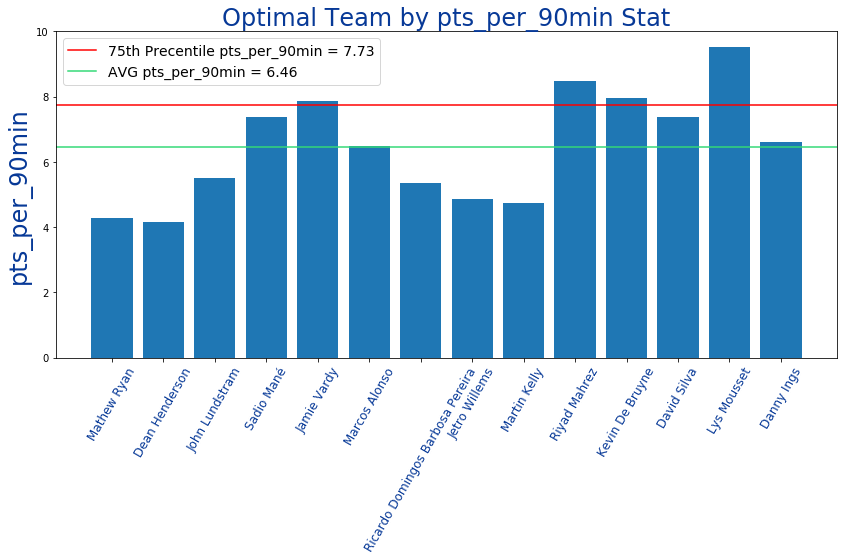

In [373]:
money_x = money_df.pts_per_90min
money_y = money_df.name
ST_75th = round(money_df.describe().pts_per_90min['75%'], 2)
ST_AVG = round(money_df.describe().pts_per_90min['mean'], 2)

plt.bar(money_y, money_x)
plt.axhline(y=ST_75th, color='r', linestyle='-', label='75th Precentile pts_per_90min = ' + str(ST_75th))
plt.axhline(y=ST_AVG, color='#33D977', linestyle='-', label='AVG pts_per_90min = ' + str(ST_AVG))
plt.ylabel('pts_per_90min', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Optimal Team by pts_per_90min Stat', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.savefig('Team_pts_per90min', bbox_inches = 'tight')
plt.show

In [374]:
top100_users = pd.read_csv('fEPL_user_data_test.csv', index_col='users')

In [375]:
top100_users.head()

,rank,user_id_num,total_points,game_week_points,formation,GKP_1,GKP_2,DEF_1,DEF_2,DEF_3,...,DEF_5,MID_1,MID_2,MID_3,MID_4,MID_5,FWD_1,FWD_2,FWD_3,user_team_pages
users,,,,,,,,,,,,,,,,,,,,,
Andrew Forey,1,4731491,969,55,"{'GKP': 1, 'DEF': 3, 'MID': 5, 'FWD': 2}",Gazzaniga-TOT-start,Ryan-BHA-sub,Tarkowski-BUR-start,Chilwell-LEI-start,Tomori-CHE-start,...,Reid-WHU-sub,De Bruyne-MCI-start,Sterling-MCI-start,Mount-CHE-start,Maddison-LEI-start,Son-TOT-start,Rashford-MUN-start,Vardy-LEI-start,Barnes-BUR-sub,https://fantasy.premierleague.com/entry/473149...
nick tanner,2,568651,955,41,"{'GKP': 1, 'DEF': 3, 'MID': 4, 'FWD': 3}",Ryan-BHA-start,McGovern-NOR-sub,Rico-BOU-start,Guilbert-AVL-start,Lundstram-SHU-start,...,Dunk-BHA-sub,Maddison-LEI-start,Salah-LIV-start,Martial-MUN-start,Alli-TOT-start,McGinn-AVL-sub,Kane-TOT-start,Rashford-MUN-start,Vardy-LEI-start,https://fantasy.premierleague.com/entry/568651...
kurt JONKERS,3,558922,953,52,"{'GKP': 1, 'DEF': 4, 'MID': 3, 'FWD': 3}",Ryan-BHA-start,McGovern-NOR-sub,Lundstram-SHU-start,Robertson-LIV-start,Pereira-LEI-start,...,Kelly-CRY-sub,Mané-LIV-start,De Bruyne-MCI-start,Tielemans-LEI-start,Dendoncker-WOL-sub,Iwobi-EVE-sub,Firmino-LIV-start,Vardy-LEI-start,Jiménez-WOL-start,https://fantasy.premierleague.com/entry/558922...
Matthew Troha,4,933902,950,30,"{'GKP': 1, 'DEF': 3, 'MID': 4, 'FWD': 3}",Schmeichel-LEI-start,McGovern-NOR-sub,Robertson-LIV-start,Lundstram-SHU-start,Rico-BOU-start,...,Kelly-CRY-sub,Pérez-LEI-start,Mané-LIV-start,Salah-LIV-start,Pulisic-CHE-start,Moutinho-WOL-sub,Jesus-MCI-start,Jiménez-WOL-start,Vardy-LEI-start,https://fantasy.premierleague.com/entry/933902...
kenneth herlihy,5,1734934,950,52,"{'GKP': 1, 'DEF': 3, 'MID': 5, 'FWD': 2}",Patrício-WOL-start,Button-BHA-sub,Söyüncü-LEI-start,Lundstram-SHU-start,Alexander-Arnold-LIV-start,...,Pieters-BUR-sub,Mount-CHE-start,Maddison-LEI-start,Mané-LIV-start,De Bruyne-MCI-start,Douglas Luiz-AVL-start,Rashford-MUN-start,Vardy-LEI-start,Abraham-CHE-sub,https://fantasy.premierleague.com/entry/173493...


### Get Stats of top 100 players

<function matplotlib.pyplot.show(*args, **kw)>

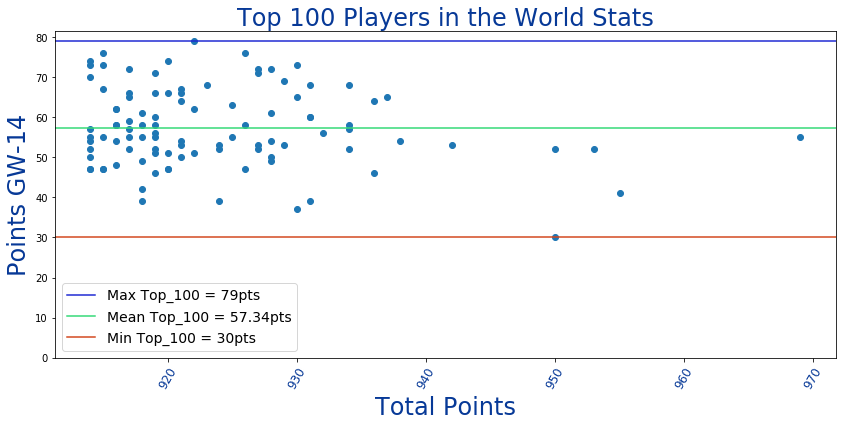

In [376]:
y =list(top100_users.game_week_points)
z =list(top100_users.total_points)

mean = np.mean(y)
maxi = np.max(y)
mini = np.min(y)

plt.scatter(z, y)
plt.ylim(bottom=0)
plt.axhline(y=maxi, color='#1D28D2', linestyle='-', label='Max Top_100 = ' + str(maxi) +'pts')
plt.axhline(y=mean, color='#33D977', linestyle='-', label='Mean Top_100 = ' + str(mean) +'pts')
plt.axhline(y=mini, color='#D2461D', linestyle='-', label='Min Top_100 = ' + str(mini) +'pts')
plt.ylabel('Points GW-'+ str(gameweek-1), fontsize = 24, color = '#073997')
plt.xlabel('Total Points', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 100 Players in the World Stats', fontsize = 24, color = '#073997')
plt.legend(fontsize = 14)
plt.savefig('Top10_Stats', bbox_inches = 'tight')
plt.show

### Function to extract names from player string

In [377]:
def partition_names(names_list):
    clean_list = [item.partition("-")[0] for item in names_list]
    return clean_list

### Function to get the list of all selected players by position

In [378]:
def get_top100_teams(team_df):
    #create lists by position
    #GK_list
    GK_list = list(team_df.GKP_1)
    GK_list.extend(list(team_df.GKP_2))
    GK_final = partition_names(GK_list)
    
    #DF_list
    DF_list = list(team_df.DEF_1)
    DF_list.extend(list(team_df.DEF_2))
    DF_list.extend(list(team_df.DEF_3))
    DF_list.extend(list(team_df.DEF_4))
    DF_list.extend(list(team_df.DEF_5))
    DF_final = partition_names(DF_list)
    
    #MD_list
    MD_list = list(team_df.MID_1)
    MD_list.extend(list(team_df.MID_2))
    MD_list.extend(list(team_df.MID_3))
    MD_list.extend(list(team_df.MID_4))
    MD_list.extend(list(team_df.MID_5))
    MD_final = partition_names(MD_list)
    
    #ST_list
    ST_list = list(team_df.FWD_1)
    ST_list.extend(list(team_df.FWD_2))
    ST_list.extend(list(team_df.FWD_3))
    ST_final = partition_names(ST_list)
    
    return GK_final, DF_final, MD_final, ST_final

In [379]:
#get the final clean list of players per position
GK_final, DF_final, MD_final, ST_final = get_top100_teams(top100_users)[0], get_top100_teams(top100_users)[1], get_top100_teams(top100_users)[2], get_top100_teams(top100_users)[3]

In [380]:
GK_final[:3]

['Gazzaniga', 'Ryan', 'Ryan']

In [381]:
MD_final[:3]

['De Bruyne', 'Maddison', 'Mané']

In [382]:
DF_final[:3]

['Tarkowski', 'Rico', 'Lundstram']

In [383]:
ST_final[:3]

['Rashford', 'Kane', 'Firmino']

### Function to get you top_n players by position ordered by # of times they were picked

In [384]:
def return_top_n(players, top_n = 10):
    ranked = Counter(players).most_common(top_n)
    return ranked

In [385]:
GK_top10 = return_top_n(GK_final)

In [386]:
GK_top10

[('Pope', 40),
 ('Ryan', 38),
 ('Button', 25),
 ('Schmeichel', 18),
 ('Gazzaniga', 17),
 ('Heaton', 13),
 ('McGovern', 12),
 ('Patrício', 6),
 ('Stekelenburg', 6),
 ('Henderson', 5)]

In [387]:
DF_top10 = return_top_n(DF_final)

In [388]:
DF_top10

[('Lundstram', 94),
 ('Söyüncü', 49),
 ('Alexander', 44),
 ('Kelly', 35),
 ('Tomori', 34),
 ('Robertson', 30),
 ('Rico', 27),
 ('Pereira', 22),
 ('Dunk', 19),
 ('Chilwell', 17)]

In [389]:
MD_top10 = return_top_n(MD_final)

In [390]:
MD_top10

[('Mané', 86),
 ('De Bruyne', 81),
 ('Maddison', 49),
 ('Son', 43),
 ('Mount', 27),
 ('Pulisic', 25),
 ('Martial', 24),
 ('Cantwell', 22),
 ('Sterling', 17),
 ('McGinn', 16)]

In [391]:
ST_top10 = return_top_n(ST_final)

In [392]:
ST_top10

[('Vardy', 100),
 ('Jiménez', 51),
 ('Abraham', 50),
 ('Ings', 23),
 ('Rashford', 16),
 ('Aubameyang', 11),
 ('Mousset', 10),
 ('Greenwood', 6),
 ('Kane', 4),
 ('Firmino', 4)]

<function matplotlib.pyplot.show(*args, **kw)>

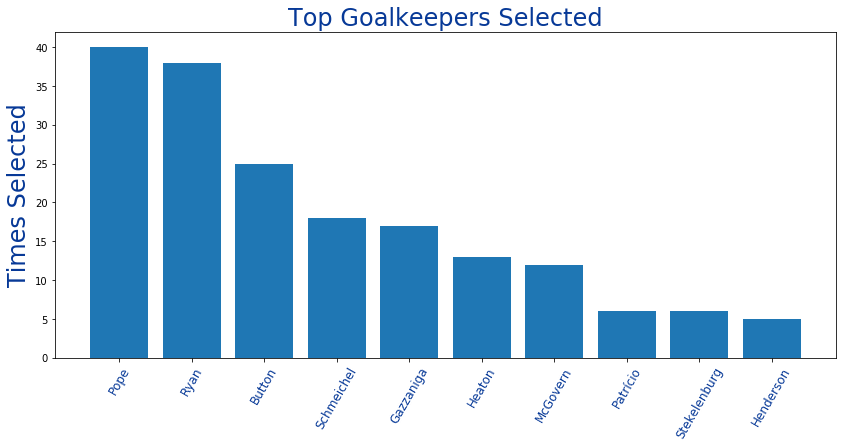

In [393]:
X = [item[0] for item in GK_top10]
Y = [item[1] for item in GK_top10]

plt.bar(X, Y)
plt.ylim(bottom=0)
# plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GF = ' + str(median))
plt.ylabel('Times Selected', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top Goalkeepers Selected', fontsize = 24, color = '#073997')
# plt.legend(fontsize = 14)
plt.savefig('Top100_GK', bbox_inches = 'tight')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

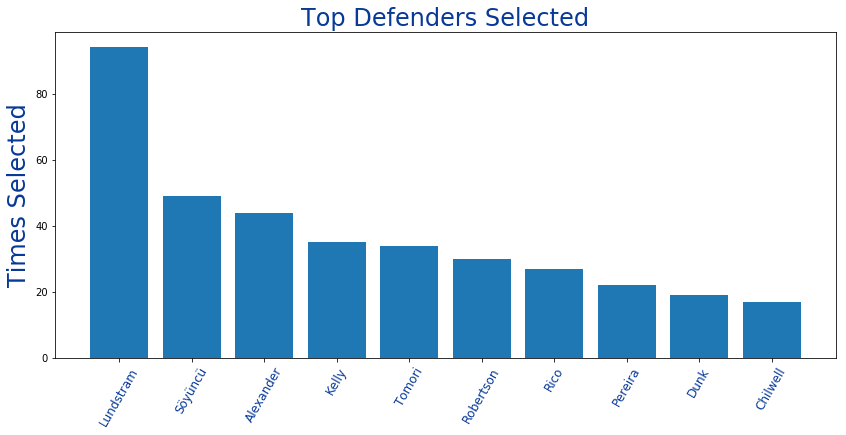

In [394]:
X = [item[0] for item in DF_top10]
Y = [item[1] for item in DF_top10]

plt.bar(X, Y)
plt.ylim(bottom=0)
# plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GF = ' + str(median))
plt.ylabel('Times Selected', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top Defenders Selected', fontsize = 24, color = '#073997')
# plt.legend(fontsize = 14)
plt.savefig('Top100_DF', bbox_inches = 'tight')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

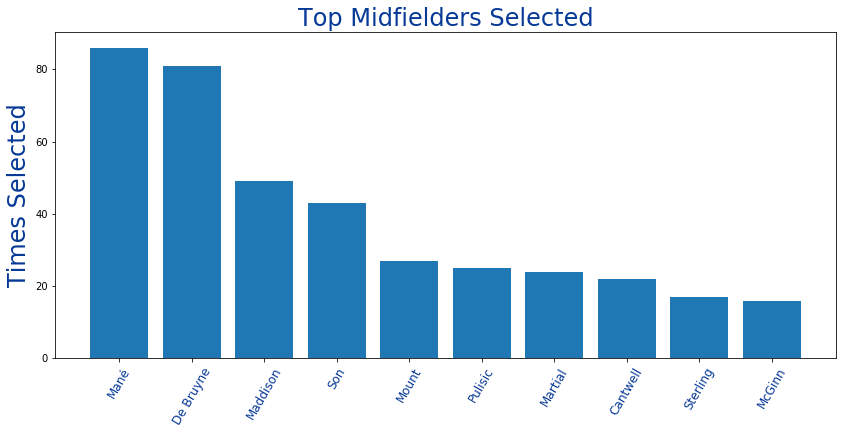

In [395]:
X = [item[0] for item in MD_top10]
Y = [item[1] for item in MD_top10]

plt.bar(X, Y)
plt.ylim(bottom=0)
# plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GF = ' + str(median))
plt.ylabel('Times Selected', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top Midfielders Selected', fontsize = 24, color = '#073997')
# plt.legend(fontsize = 14)
plt.savefig('Top100_MD', bbox_inches = 'tight')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

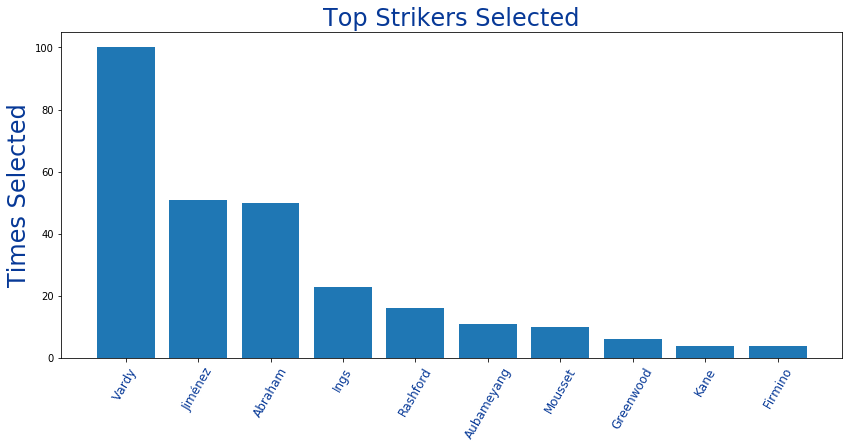

In [396]:
X = [item[0] for item in ST_top10]
Y = [item[1] for item in ST_top10]

plt.bar(X, Y)
plt.ylim(bottom=0)
# plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GF = ' + str(median))
plt.ylabel('Times Selected', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top Strikers Selected', fontsize = 24, color = '#073997')
# plt.legend(fontsize = 14)
plt.savefig('Top100_ST', bbox_inches = 'tight')
plt.show

In [397]:
top_managers_team = GK_top10[:2]+ DF_top10[:5] + MD_top10[:5] + ST_top10[:3]

In [398]:
top_managers_team

[('Pope', 40),
 ('Ryan', 38),
 ('Lundstram', 94),
 ('Söyüncü', 49),
 ('Alexander', 44),
 ('Kelly', 35),
 ('Tomori', 34),
 ('Mané', 86),
 ('De Bruyne', 81),
 ('Maddison', 49),
 ('Son', 43),
 ('Mount', 27),
 ('Vardy', 100),
 ('Jiménez', 51),
 ('Abraham', 50)]

<function matplotlib.pyplot.show(*args, **kw)>

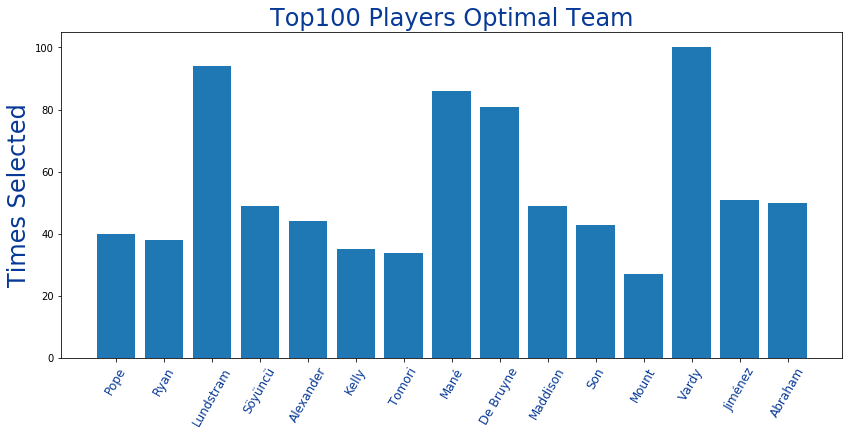

In [399]:
X = [item[0] for item in top_managers_team]
Y = [item[1] for item in top_managers_team]

plt.bar(X, Y)
plt.ylim(bottom=0)
# plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GF = ' + str(median))
plt.ylabel('Times Selected', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top100 Players Optimal Team', fontsize = 24, color = '#073997')
# plt.legend(fontsize = 14)
plt.savefig('Top100_Team', bbox_inches = 'tight')
plt.show

### Latest Injury Updates from independant site that updates faster than the Fantasy site

In [400]:
injuries = 'http://www.premierinjuries.com/?fbclid=IwAR1Uz0TTwRMOvsq1jlefIztPPg7qtPdnag3zrHxh_39wV4CZoMG0ZWq6MYU'
injuries_tab = pd.read_html(injuries)[0]

In [401]:
injuries_tab

,Player,Reason
0,Kiko Femenia,Other
1,Anwar El Ghazi,Knee Injury
2,Scott Dann,Ankle/Foot Injury
3,Allan Saint-Maximin,Other
4,Charlie Taylor,Thigh Injury
5,Andy Carroll,Chest/Abdominal Injury
6,Richarlison de Andrade,Other
7,Theo Walcott,Other
8,Morgan Schneiderlin,Other
9,Seamus Coleman,Other


In [402]:
top100_users.head()

,rank,user_id_num,total_points,game_week_points,formation,GKP_1,GKP_2,DEF_1,DEF_2,DEF_3,...,DEF_5,MID_1,MID_2,MID_3,MID_4,MID_5,FWD_1,FWD_2,FWD_3,user_team_pages
users,,,,,,,,,,,,,,,,,,,,,
Andrew Forey,1,4731491,969,55,"{'GKP': 1, 'DEF': 3, 'MID': 5, 'FWD': 2}",Gazzaniga-TOT-start,Ryan-BHA-sub,Tarkowski-BUR-start,Chilwell-LEI-start,Tomori-CHE-start,...,Reid-WHU-sub,De Bruyne-MCI-start,Sterling-MCI-start,Mount-CHE-start,Maddison-LEI-start,Son-TOT-start,Rashford-MUN-start,Vardy-LEI-start,Barnes-BUR-sub,https://fantasy.premierleague.com/entry/473149...
nick tanner,2,568651,955,41,"{'GKP': 1, 'DEF': 3, 'MID': 4, 'FWD': 3}",Ryan-BHA-start,McGovern-NOR-sub,Rico-BOU-start,Guilbert-AVL-start,Lundstram-SHU-start,...,Dunk-BHA-sub,Maddison-LEI-start,Salah-LIV-start,Martial-MUN-start,Alli-TOT-start,McGinn-AVL-sub,Kane-TOT-start,Rashford-MUN-start,Vardy-LEI-start,https://fantasy.premierleague.com/entry/568651...
kurt JONKERS,3,558922,953,52,"{'GKP': 1, 'DEF': 4, 'MID': 3, 'FWD': 3}",Ryan-BHA-start,McGovern-NOR-sub,Lundstram-SHU-start,Robertson-LIV-start,Pereira-LEI-start,...,Kelly-CRY-sub,Mané-LIV-start,De Bruyne-MCI-start,Tielemans-LEI-start,Dendoncker-WOL-sub,Iwobi-EVE-sub,Firmino-LIV-start,Vardy-LEI-start,Jiménez-WOL-start,https://fantasy.premierleague.com/entry/558922...
Matthew Troha,4,933902,950,30,"{'GKP': 1, 'DEF': 3, 'MID': 4, 'FWD': 3}",Schmeichel-LEI-start,McGovern-NOR-sub,Robertson-LIV-start,Lundstram-SHU-start,Rico-BOU-start,...,Kelly-CRY-sub,Pérez-LEI-start,Mané-LIV-start,Salah-LIV-start,Pulisic-CHE-start,Moutinho-WOL-sub,Jesus-MCI-start,Jiménez-WOL-start,Vardy-LEI-start,https://fantasy.premierleague.com/entry/933902...
kenneth herlihy,5,1734934,950,52,"{'GKP': 1, 'DEF': 3, 'MID': 5, 'FWD': 2}",Patrício-WOL-start,Button-BHA-sub,Söyüncü-LEI-start,Lundstram-SHU-start,Alexander-Arnold-LIV-start,...,Pieters-BUR-sub,Mount-CHE-start,Maddison-LEI-start,Mané-LIV-start,De Bruyne-MCI-start,Douglas Luiz-AVL-start,Rashford-MUN-start,Vardy-LEI-start,Abraham-CHE-sub,https://fantasy.premierleague.com/entry/173493...


In [403]:
test = top100_users.formation

### Extract formations as a list in a readable format

In [404]:
formations = [item.split(",")[1][8] + "-" + item.split(",")[2][8] + "-" + item.split(",")[3][8] for item in test]

In [405]:
formations[:5]

['3-5-2', '3-4-3', '4-3-3', '3-4-3', '3-5-2']

### Use top_n function to get a tuple of ranked formations by count

In [406]:
top_form = return_top_n(formations, 6)

In [407]:
top_form

[('3-5-2', 30),
 ('3-4-3', 28),
 ('4-4-2', 28),
 ('4-3-3', 7),
 ('4-5-1', 6),
 ('5-4-1', 1)]

<function matplotlib.pyplot.show(*args, **kw)>

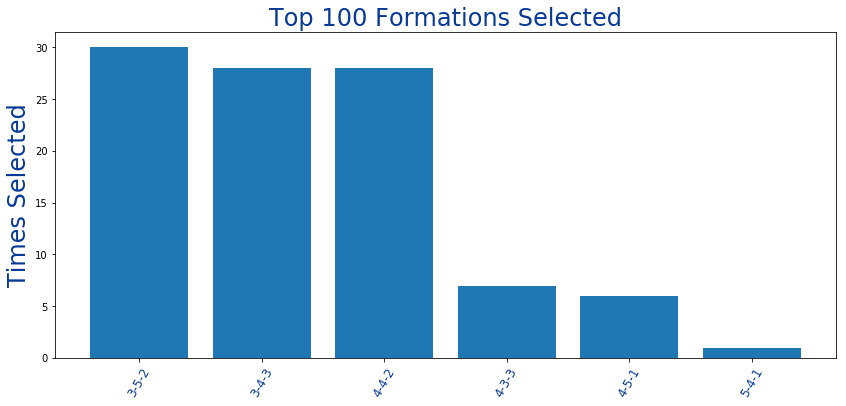

In [408]:
X = [item[0] for item in top_form]
Y = [item[1] for item in top_form]

plt.bar(X, Y)
plt.ylim(bottom=0)
# plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GF = ' + str(median))
plt.ylabel('Times Selected', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 100 Formations Selected', fontsize = 24, color = '#073997')
# plt.legend(fontsize = 14)
plt.savefig('Top100_Forma', bbox_inches = 'tight')
plt.show